In [13]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType
from pyspark.sql.window import Window

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import utils.data_processing_bronze_table
import utils.data_processing_silver_table
import utils.data_processing_gold_table

import utils.clickstream_bronze_table
import utils.clickstream_silver_table
import utils.clickstream_gold_table


In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/03 13:59:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# set up config
snapshot_date_str = "2023-01-01"

start_date_str = "2023-01-01"
end_date_str = "2024-12-01"

In [4]:
# generate list of dates to process
def generate_first_of_month_dates(start_date_str, end_date_str):
    # Convert the date strings to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    
    # List to store the first of month dates
    first_of_month_dates = []

    # Start from the first of the month of the start_date
    current_date = datetime(start_date.year, start_date.month, 1)

    while current_date <= end_date:
        # Append the date in yyyy-mm-dd format
        first_of_month_dates.append(current_date.strftime("%Y-%m-%d"))
        
        # Move to the first of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return first_of_month_dates

dates_str_lst = generate_first_of_month_dates(start_date_str, end_date_str)
dates_str_lst

['2023-01-01',
 '2023-02-01',
 '2023-03-01',
 '2023-04-01',
 '2023-05-01',
 '2023-06-01',
 '2023-07-01',
 '2023-08-01',
 '2023-09-01',
 '2023-10-01',
 '2023-11-01',
 '2023-12-01',
 '2024-01-01',
 '2024-02-01',
 '2024-03-01',
 '2024-04-01',
 '2024-05-01',
 '2024-06-01',
 '2024-07-01',
 '2024-08-01',
 '2024-09-01',
 '2024-10-01',
 '2024-11-01',
 '2024-12-01']

In [5]:
# connect to source back end - IRL connect to back end source system
csv_file_path = "data/feature_clickstream.csv"

# load data - IRL ingest from back end source system
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

In [6]:
df.show()

+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----------+-------------+
|fe_1|fe_2|fe_3|fe_4|fe_5|fe_6|fe_7|fe_8|fe_9|fe_10|fe_11|fe_12|fe_13|fe_14|fe_15|fe_16|fe_17|fe_18|fe_19|fe_20|Customer_ID|snapshot_date|
+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----------+-------------+
|  63| 118|  80| 121|  55| 193| 111| 112|-101|   83|  164|  105|  -16|  -81| -126|  114|   35|   85|  -73|   76| CUS_0x1037|   2023-01-01|
|-108| 182| 123|   4| -56|  27|  25|  -6| 284|  222|  203|  190|  -14|  -96|  200|   35|  130|   94|  111|   75| CUS_0x1069|   2023-01-01|
| -13|   8|  87| 166| 214| -98| 215| 152| 129|  139|   14|  203|   26|   86|  171|  125| -130|  354|   17|  302| CUS_0x114a|   2023-01-01|
| -85|  45| 200|  89| 128|  54|  76|  51|  61|  139|    6|  197|  172|   96|  174|  163|   37|  207|  180|  118| CUS_0x1184|   2023-01-01|
|  55| 120| 226| -86| 253| 

In [7]:
#check if customer ID is unique
col_name = "Customer_ID"

# Count total rows
total_rows = df.count()

# Count distinct values in the column
unique_values = df.select(col(col_name)).distinct().count()

# Compare and print result
if total_rows == unique_values:
    print(f"Column '{col_name}' has unique values (like a primary key).")
else:
    print(f"Column '{col_name}' is NOT unique. Total: {total_rows}, Unique: {unique_values}")

[Stage 6:>                                                          (0 + 5) / 5]

Column 'Customer_ID' is NOT unique. Total: 215376, Unique: 8974


Since Customer_ID is not unique, we are dealing with some kind of time series features

### Extract features from time series 

In [8]:
# List of feature columns
feature_cols = [f"fe_{i}" for i in range(1, 21)]

In [9]:
# Keep only latest record for each customer
# Latest Snapshot Features (per customer)
latest_window = Window.partitionBy("Customer_ID").orderBy(F.col("snapshot_date").desc())

latest_df = df.withColumn("row_num", F.row_number().over(latest_window)) \
              .filter(F.col("row_num") == 1) \
              .drop("row_num")

In [10]:
# Aggregated Features (per customer across all time)
agg_exprs = []
for f_col in feature_cols:
    agg_exprs.extend([
        F.mean(f_col).alias(f"{f_col}_mean"),
        F.stddev(f_col).alias(f"{f_col}_stddev"),
        F.min(f_col).alias(f"{f_col}_min"),
        F.max(f_col).alias(f"{f_col}_max"),
    ])

agg_df = df.groupBy("Customer_ID").agg(*agg_exprs)

In [11]:
#Lag/Change Features (difference from previous snapshot)
lag_window = Window.partitionBy("Customer_ID").orderBy("snapshot_date")

df_with_lags = df
for f_col in feature_cols:
    df_with_lags = df_with_lags.withColumn(f"{f_col}_lag", F.lag(f_col).over(lag_window))
    df_with_lags = df_with_lags.withColumn(f"{f_col}_change", F.col(f_col) - F.col(f"{f_col}_lag"))

# Get the most recent change row per customer
latest_changes = df_with_lags.withColumn("row_num", F.row_number().over(latest_window)) \
                             .filter("row_num = 1") \
                             .select("Customer_ID", *[f"{c}_change" for c in feature_cols])

In [12]:
# Combine all features
# Start with most recent snapshot (base)
features_df = latest_df.select("Customer_ID", *feature_cols)

# Join all blocks
features_df = features_df \
    .join(agg_df, on="Customer_ID", how="left") \
    .join(latest_changes, on="Customer_ID", how="left")

In [13]:
features_df.show()

[Stage 18:>                                                         (0 + 1) / 1]

+-----------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------------------+------------------+--------+--------+------------------+------------------+--------+--------+------------------+------------------+--------+--------+------------------+------------------+--------+--------+------------------+------------------+--------+--------+------------------+------------------+--------+--------+------------------+------------------+--------+--------+------------------+------------------+--------+--------+------------------+------------------+--------+--------+------------------+------------------+---------+---------+------------------+------------------+---------+---------+------------------+------------------+---------+---------+------------------+------------------+---------+---------+------------------+------------------+---------+---------+------------------+------------------+---------+---------+------------------+-----

In [14]:
features_df_cols = features_df.columns[1:]

In [15]:
#check if customer ID is unique in features_df
col_name = "Customer_ID"

# Count total rows
total_rows = features_df.count()

# Count distinct values in the column
unique_values = features_df.select(col(col_name)).distinct().count()

# Compare and print result
if total_rows == unique_values:
    print(f"Column '{col_name}' has unique values (like a primary key).")
else:
    print(f"Column '{col_name}' is NOT unique. Total: {total_rows}, Unique: {unique_values}")

Column 'Customer_ID' has unique values (like a primary key).


We have transformed the time series based data to features that can be used to do EDA/training. (Each customer ID only have one label so the features have to be a single row)

### Read Label store to combine with features extracted so we can do EDA

In [16]:
# Define schema manually
schema = StructType([
    StructField("loan_id", StringType(), True),
    StructField("Customer_ID", StringType(), True),
    StructField("label", IntegerType(), True),
    StructField("label_def", StringType(), True),
    StructField("snapshot_date", DateType(), True)
])

#get data from label store
lms_folder_path = "datamart/gold/label_store/"

# List all non-empty parquet files
valid_files = []
for file in os.listdir(lms_folder_path):
    full_path = os.path.join(lms_folder_path, file)
    if file.endswith(".parquet") and os.path.getsize(full_path) > 0:
        valid_files.append(full_path)

# Check if there are any valid files
if valid_files:
    lms_df = spark.read.schema(schema).parquet(*valid_files)
    lms_df.show()
else:
    print("No non-empty Parquet files found.")

+--------------------+-----------+-----+----------+-------------+
|             loan_id|Customer_ID|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x1037_2023_0...| CUS_0x1037|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1069_2023_0...| CUS_0x1069|    0|30dpd_6mob|   2023-07-01|
|CUS_0x114a_2023_0...| CUS_0x114a|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1184_2023_0...| CUS_0x1184|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1297_2023_0...| CUS_0x1297|    1|30dpd_6mob|   2023-07-01|
|CUS_0x12fb_2023_0...| CUS_0x12fb|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1325_2023_0...| CUS_0x1325|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1341_2023_0...| CUS_0x1341|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1375_2023_0...| CUS_0x1375|    1|30dpd_6mob|   2023-07-01|
|CUS_0x13a8_2023_0...| CUS_0x13a8|    0|30dpd_6mob|   2023-07-01|
|CUS_0x13ef_2023_0...| CUS_0x13ef|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1440_2023_0...| CUS_0x1440|    0|30dpd_6mob|   2023-07-01|
|CUS_0x144

In [17]:
#check if customer ID is unique in label store
col_name = "Customer_ID"

# Count total rows
total_rows = lms_df.count()

# Count distinct values in the column
unique_values = lms_df.select(col(col_name)).distinct().count()

# Compare and print result
if total_rows == unique_values:
    print(f"Column '{col_name}' has unique values (like a primary key).")
else:
    print(f"Column '{col_name}' is NOT unique. Total: {total_rows}, Unique: {unique_values}")

Column 'Customer_ID' has unique values (like a primary key).


In [18]:
# We join lms_df with the features that we generated

# Perform left join
eda_df = lms_df.join(features_df, on="Customer_ID", how="left")

# Show result
eda_df.show()

+-----------+--------------------+-----+----------+-------------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------------------+------------------+--------+--------+------------------+------------------+--------+--------+------------------+------------------+--------+--------+------------------+------------------+--------+--------+------------------+------------------+--------+--------+------------------+------------------+--------+--------+------------------+------------------+--------+--------+------------------+------------------+--------+--------+------------------+------------------+--------+--------+------------------+------------------+---------+---------+------------------+------------------+---------+---------+------------------+------------------+---------+---------+------------------+------------------+---------+---------+------------------+------------------+---------+---------+------------------+-----------

In [19]:
# convert to pandas df for ploting
pandas_df = eda_df.select(["label"] + features_df_cols).toPandas()

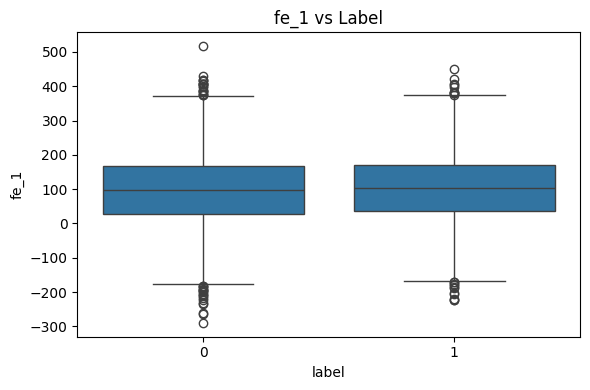

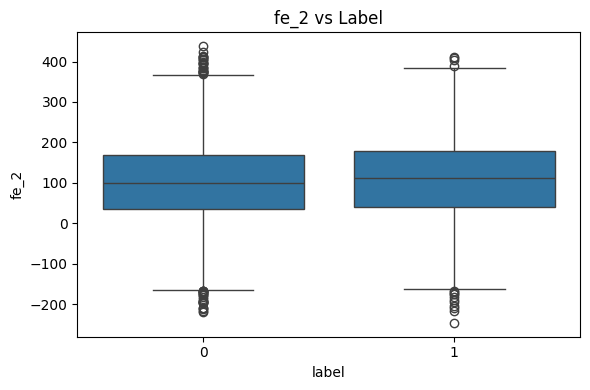

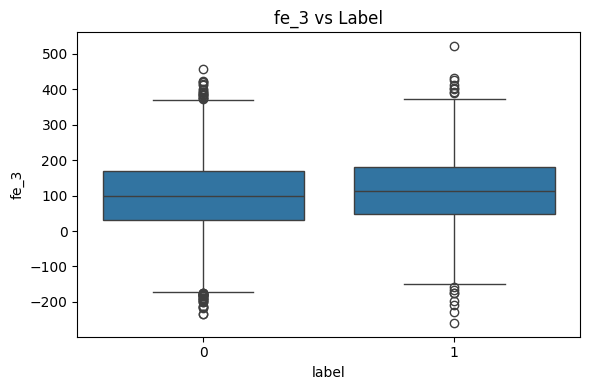

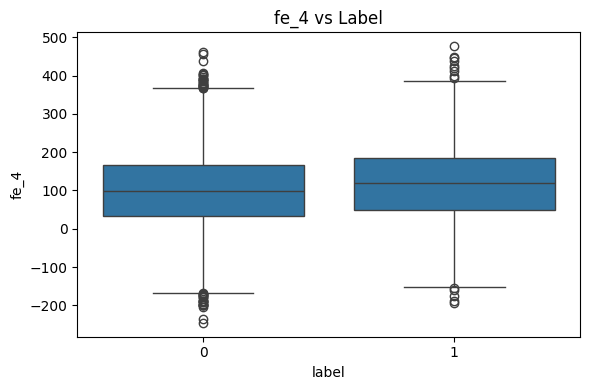

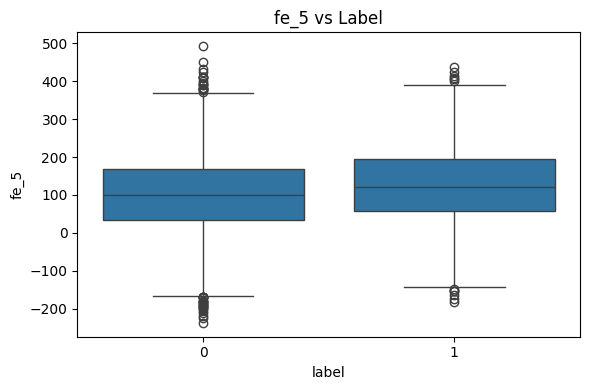

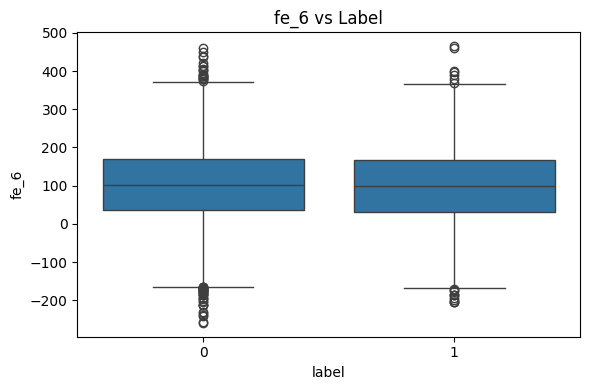

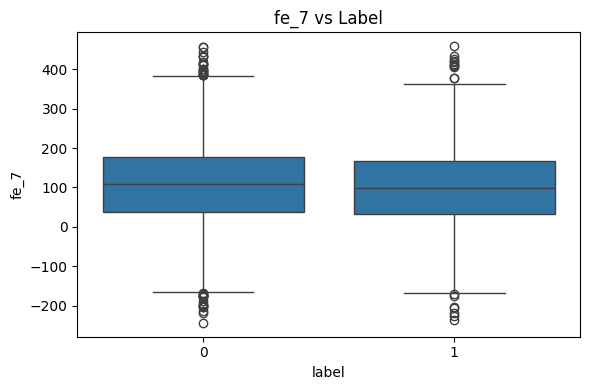

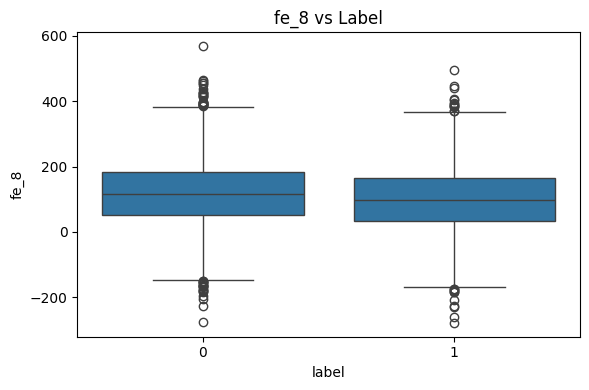

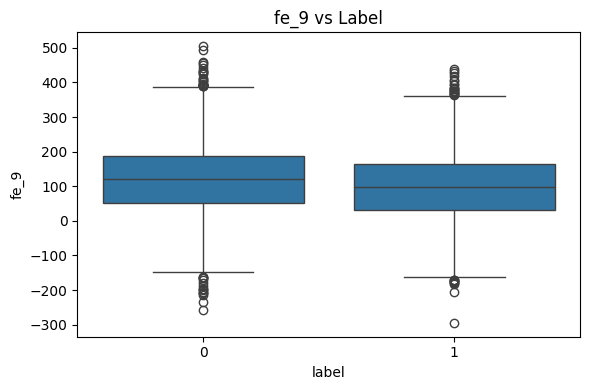

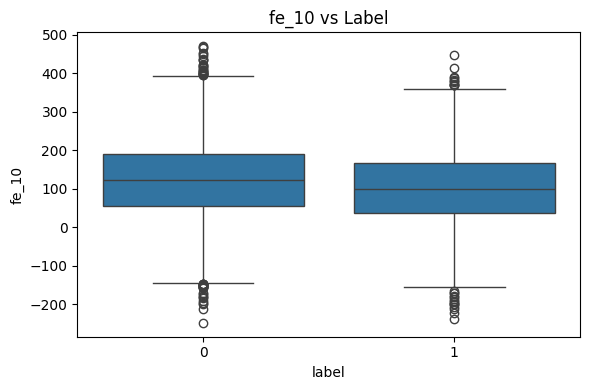

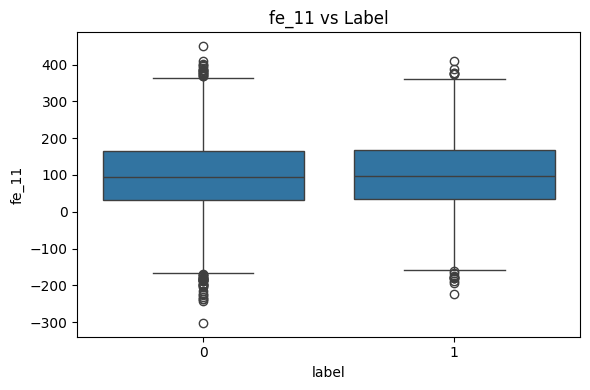

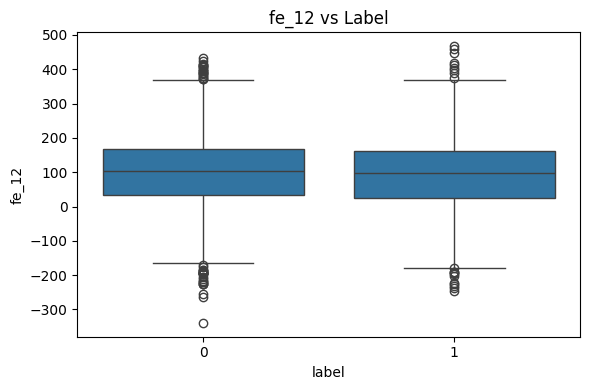

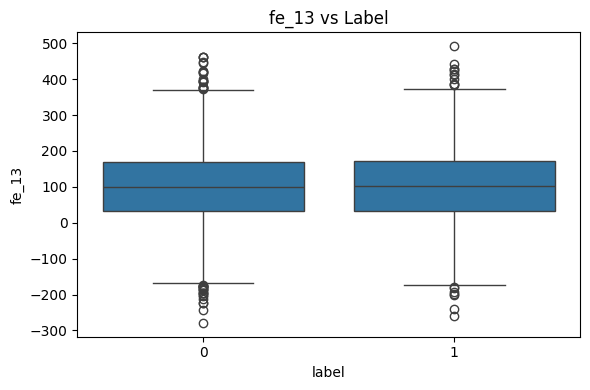

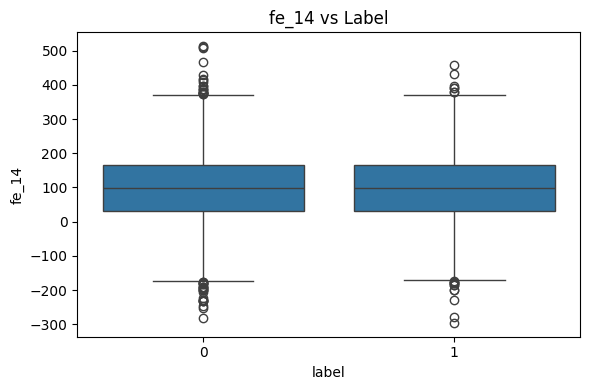

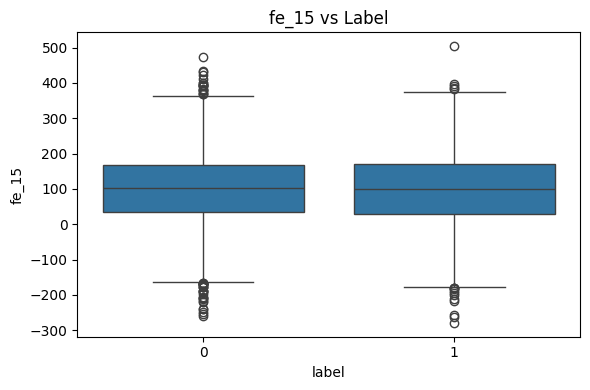

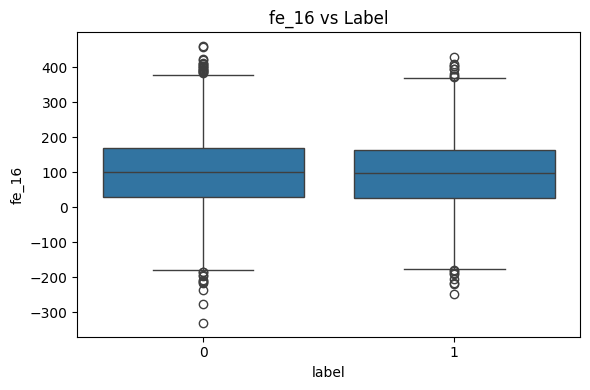

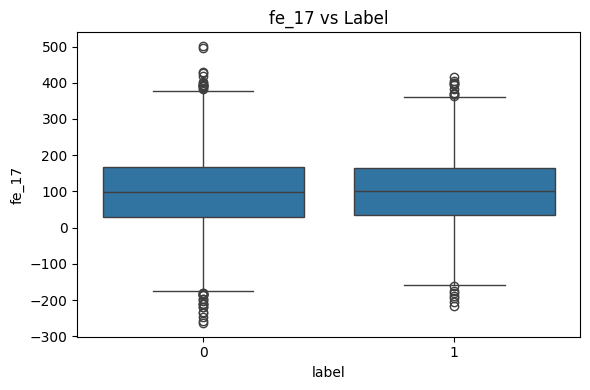

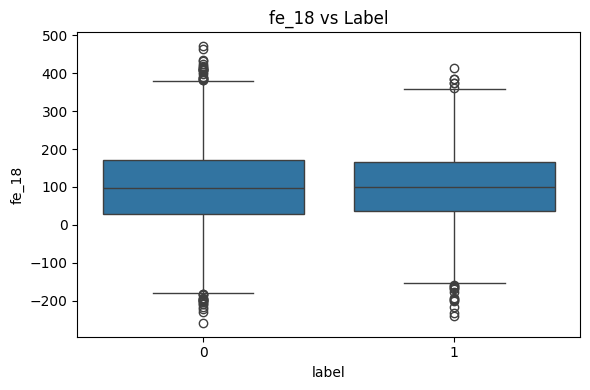

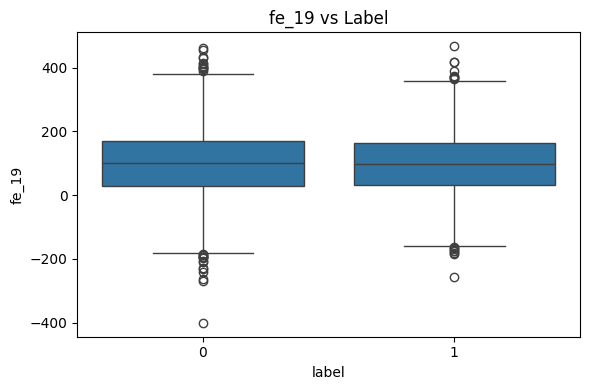

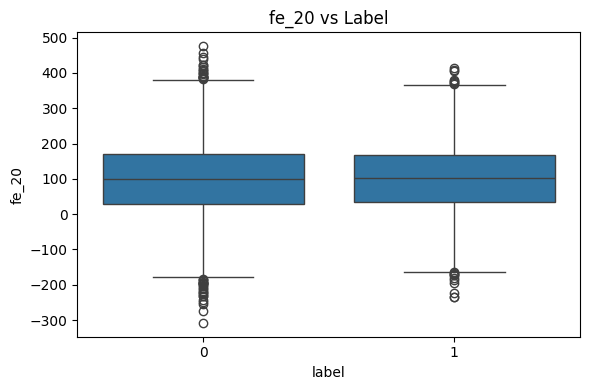

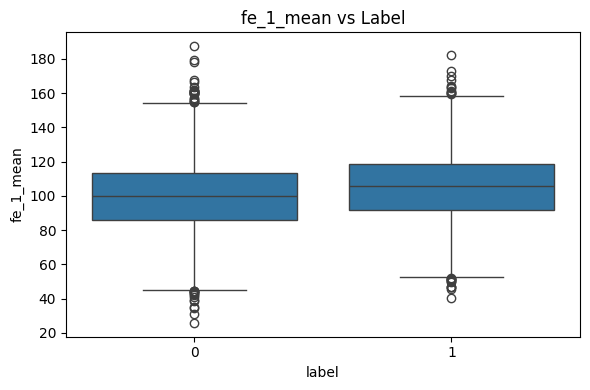

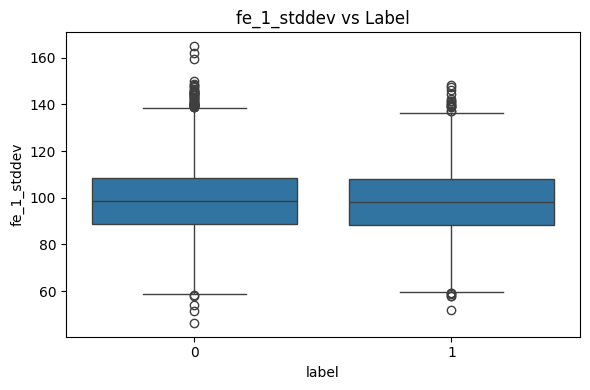

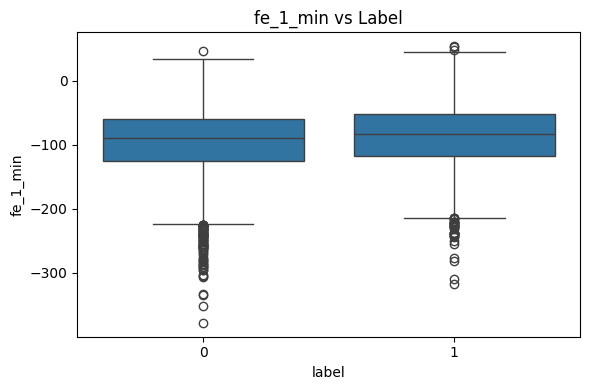

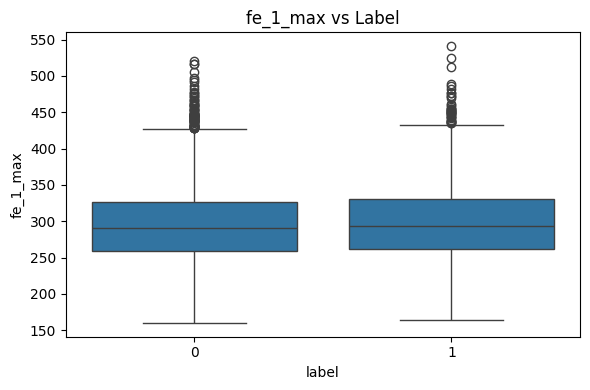

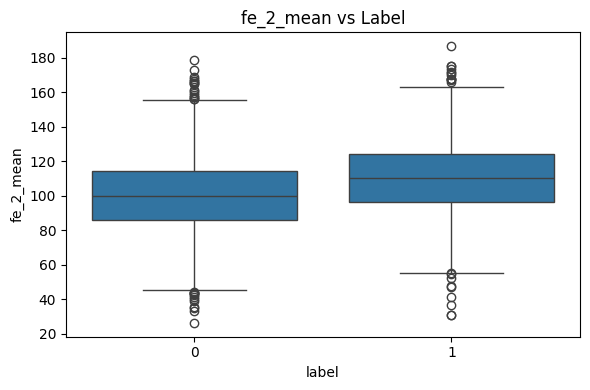

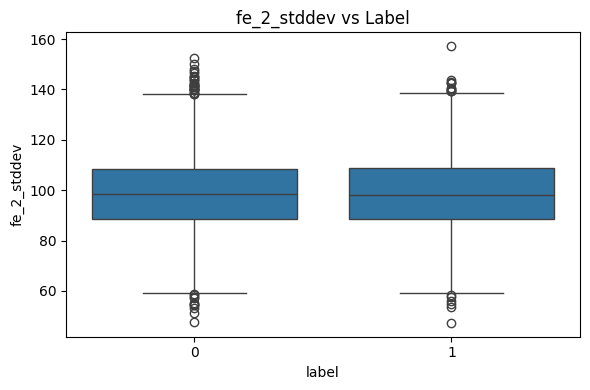

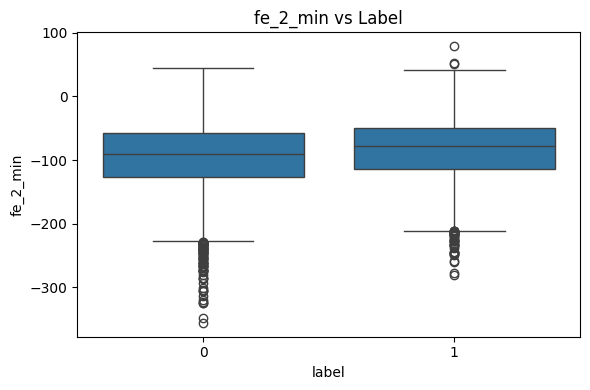

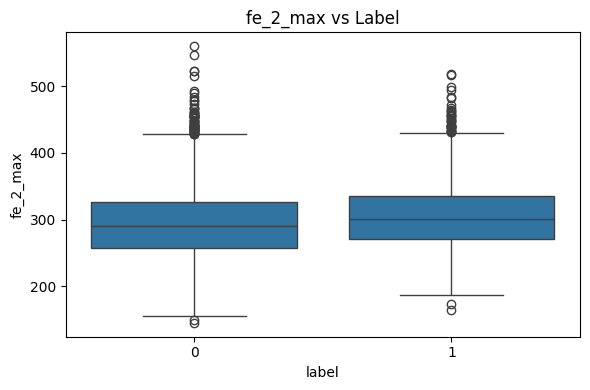

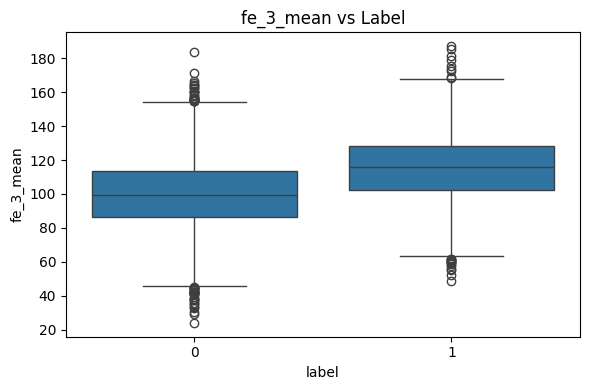

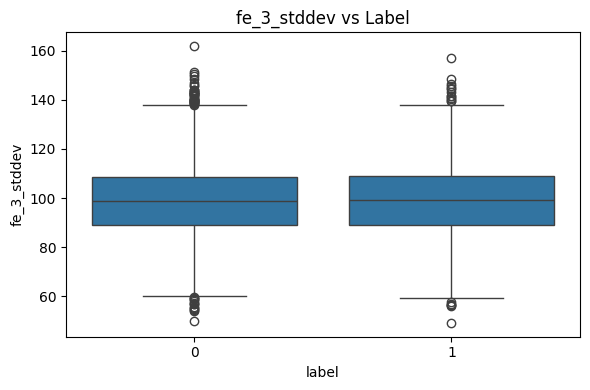

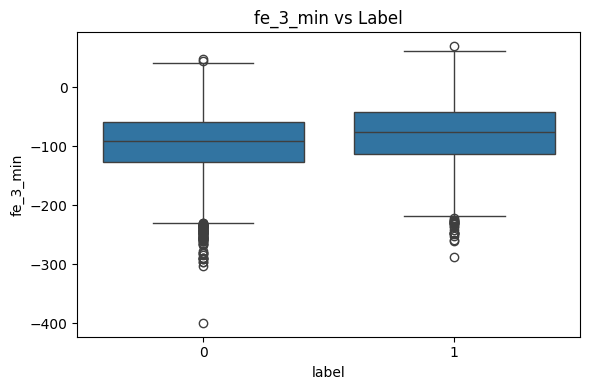

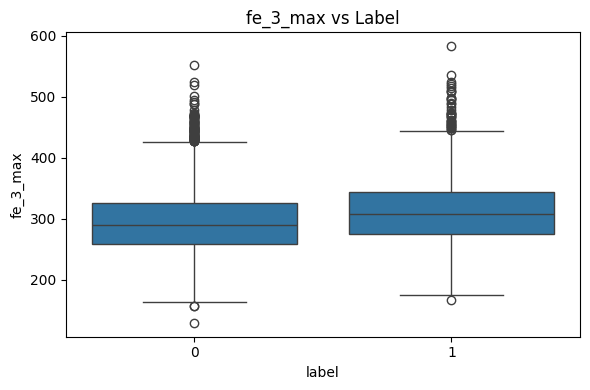

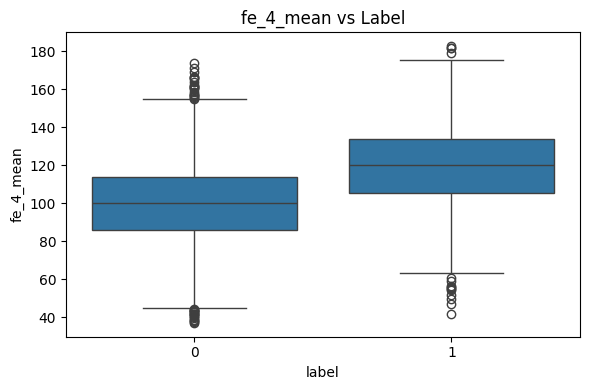

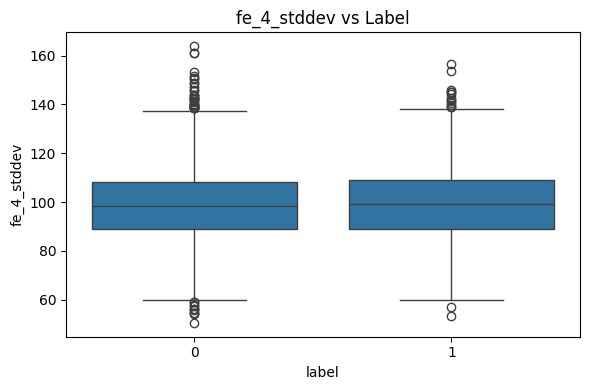

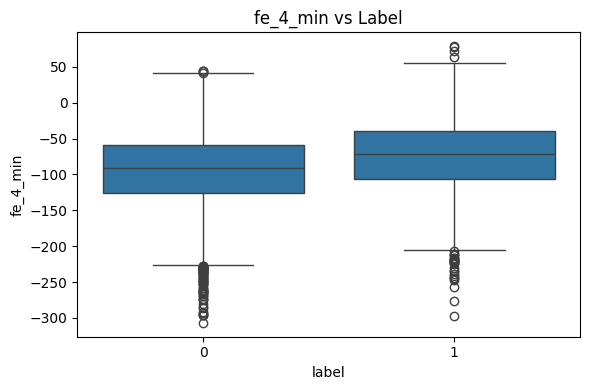

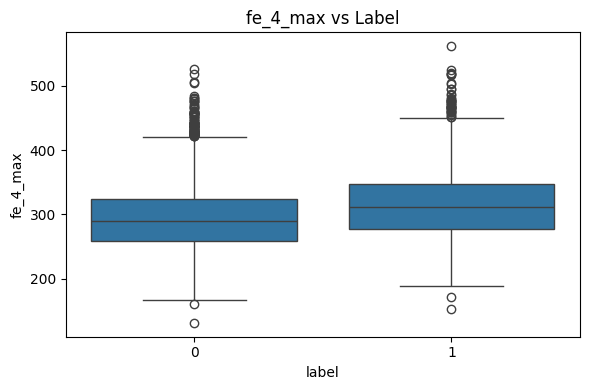

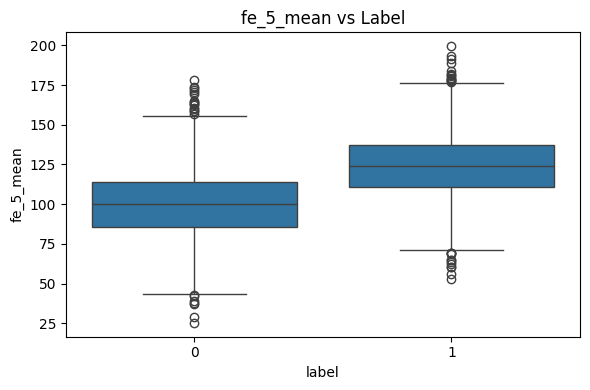

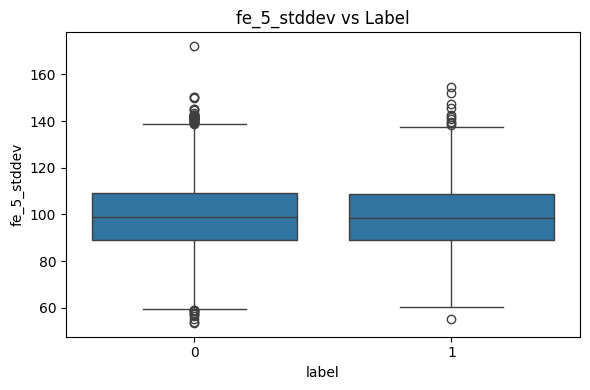

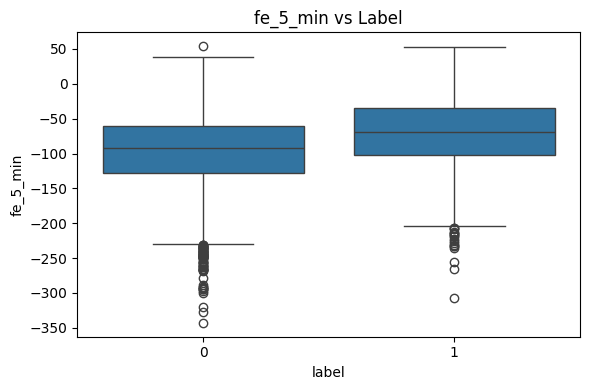

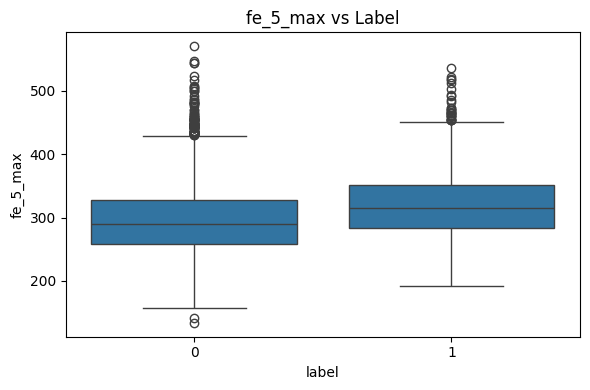

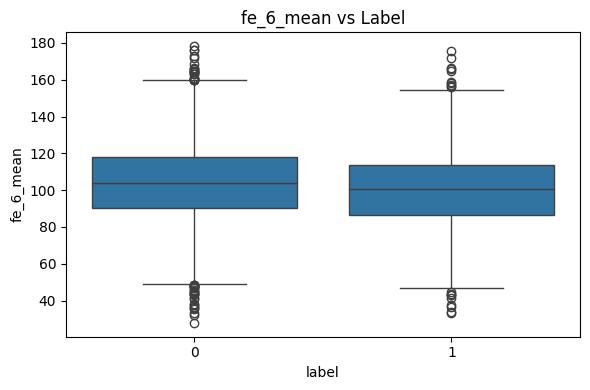

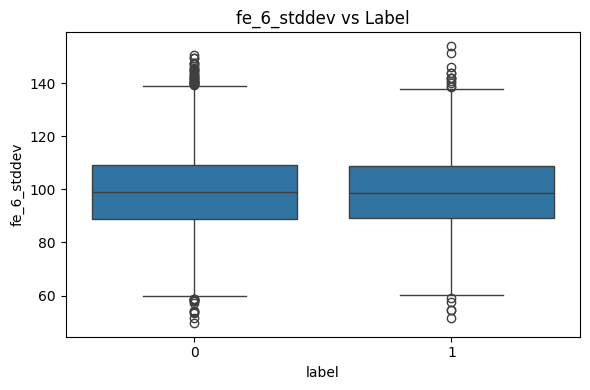

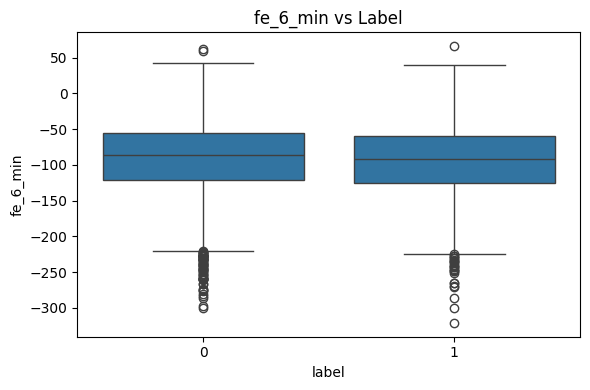

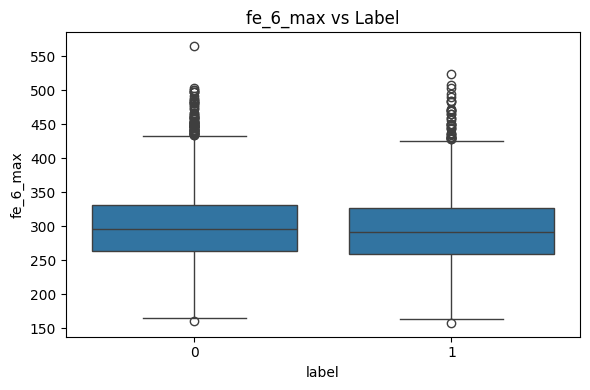

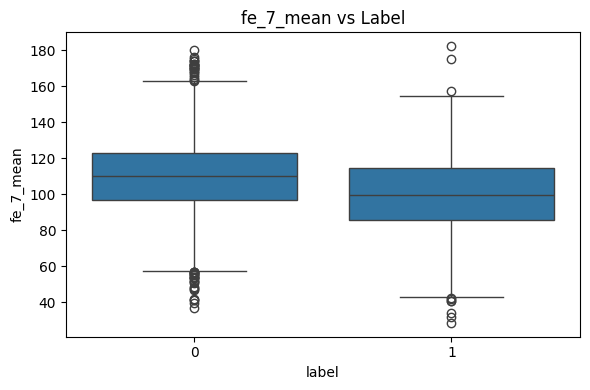

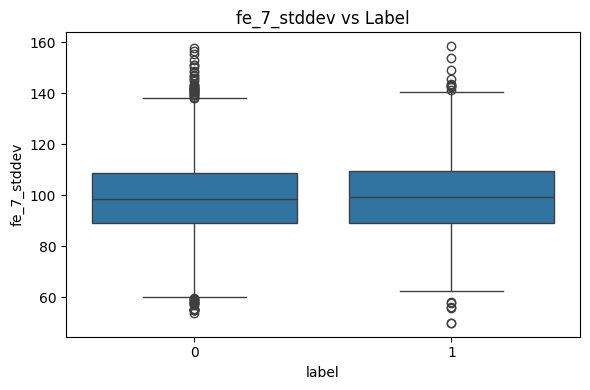

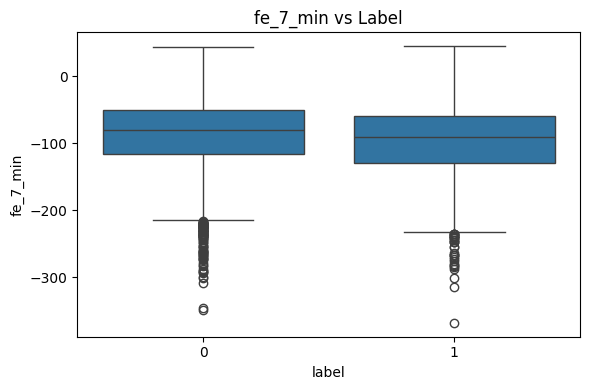

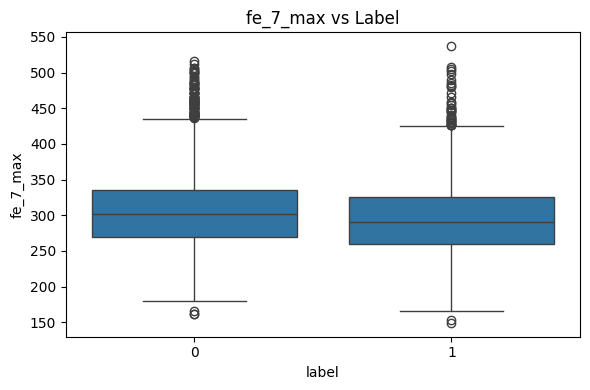

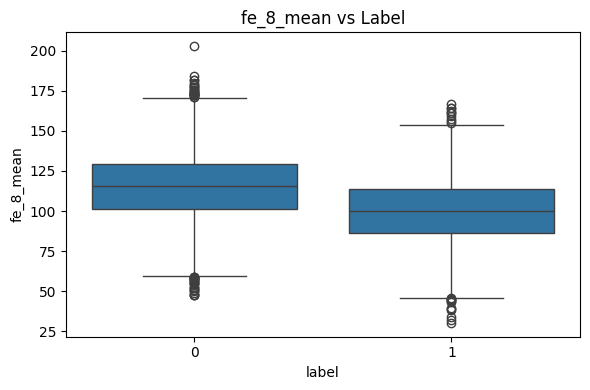

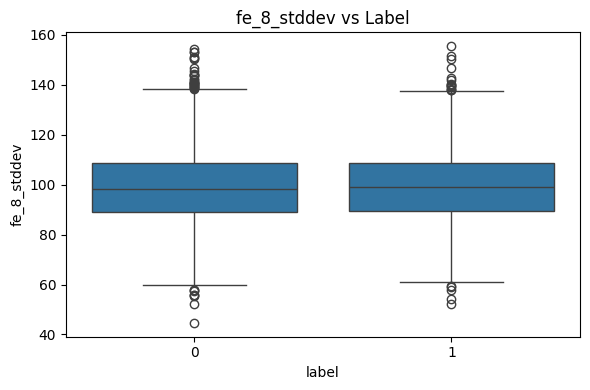

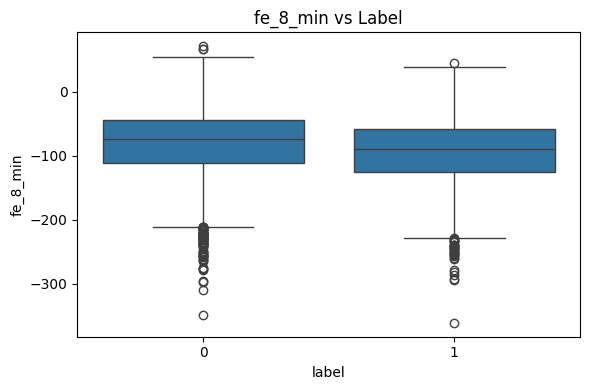

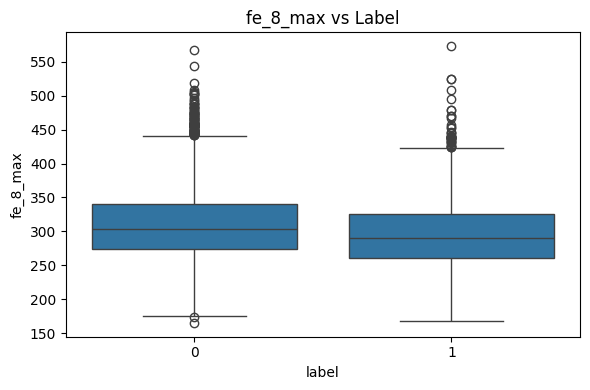

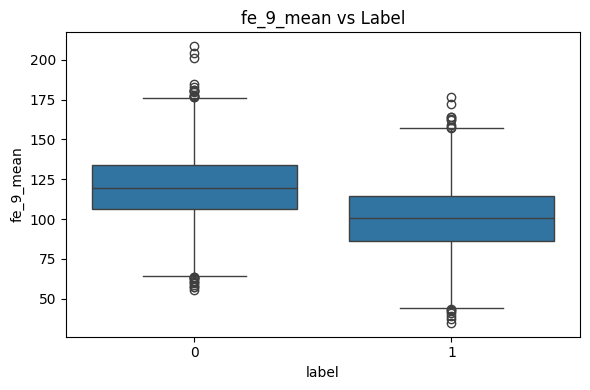

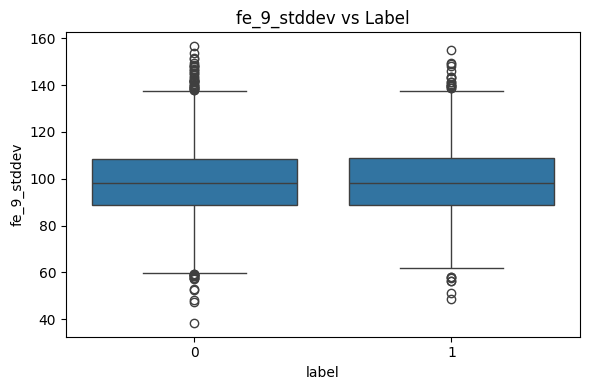

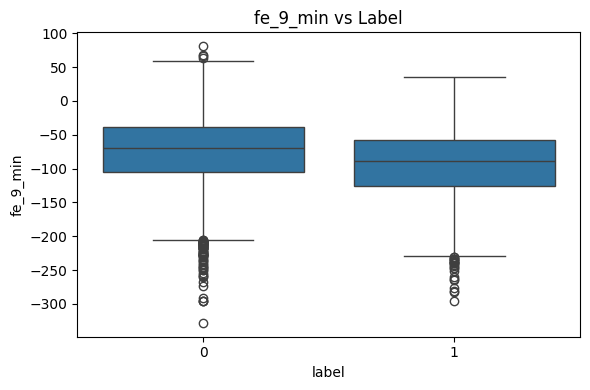

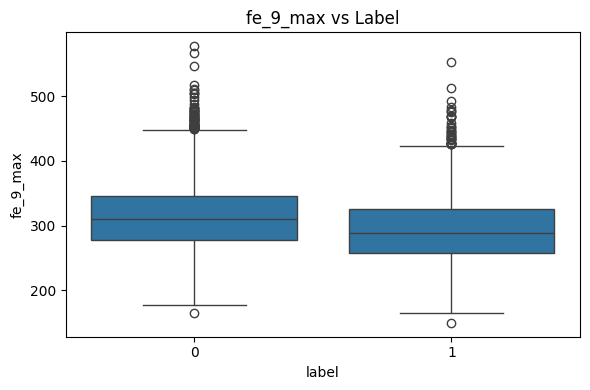

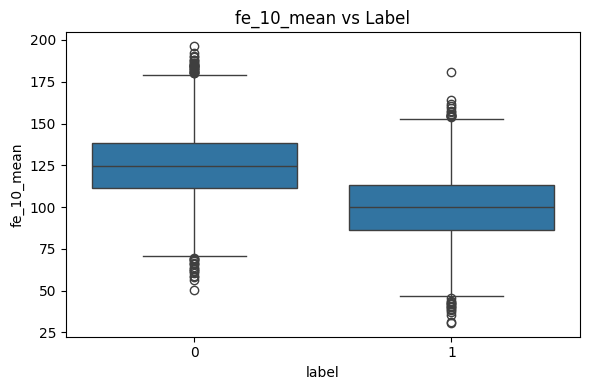

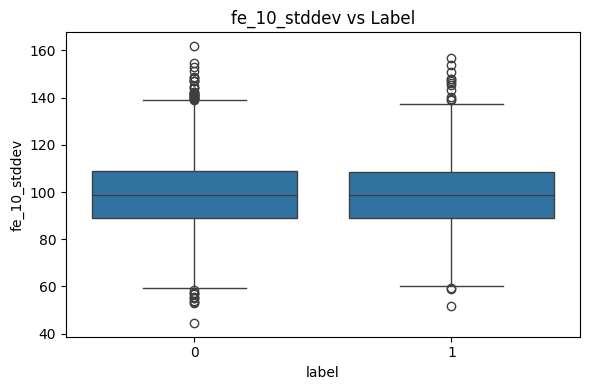

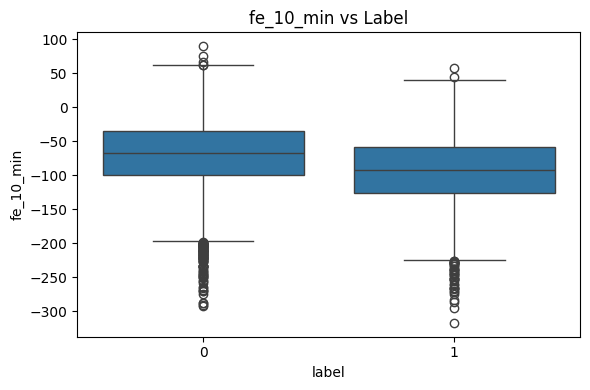

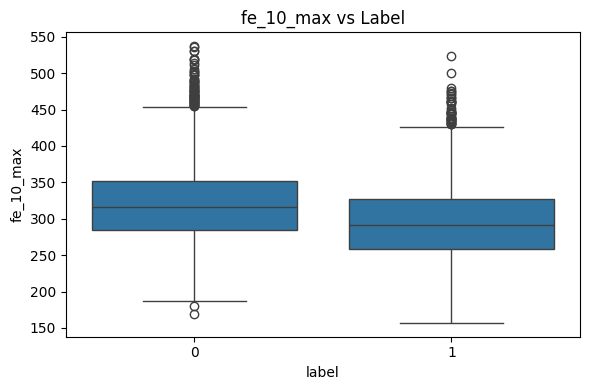

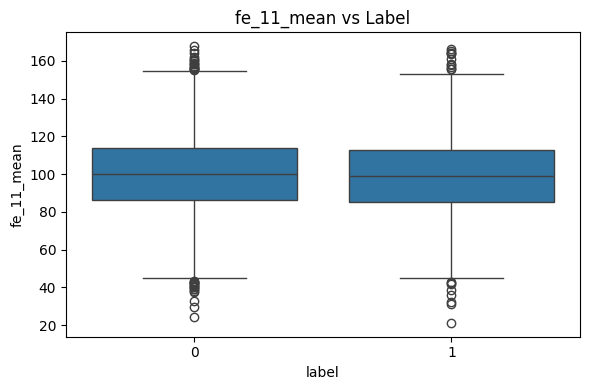

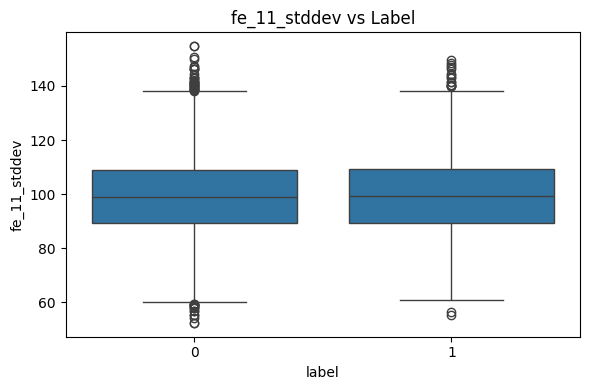

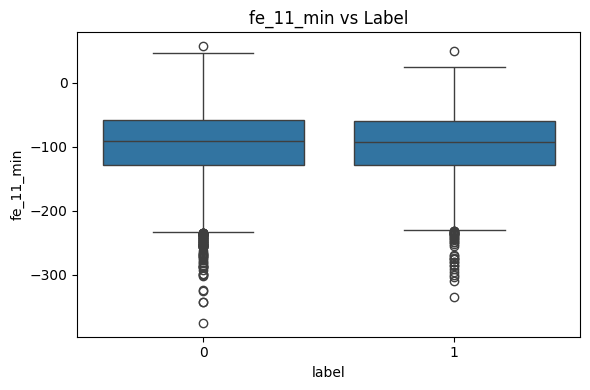

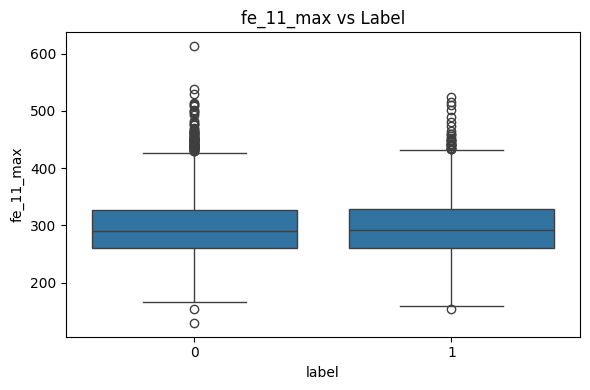

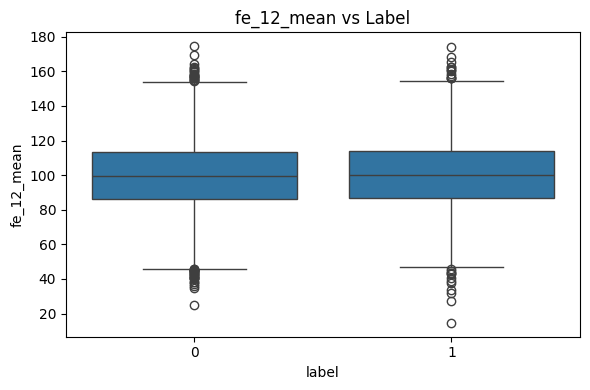

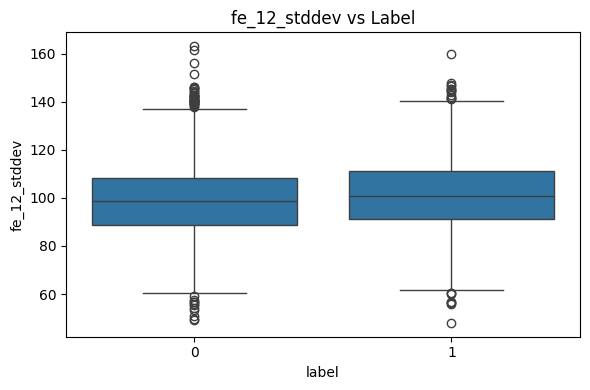

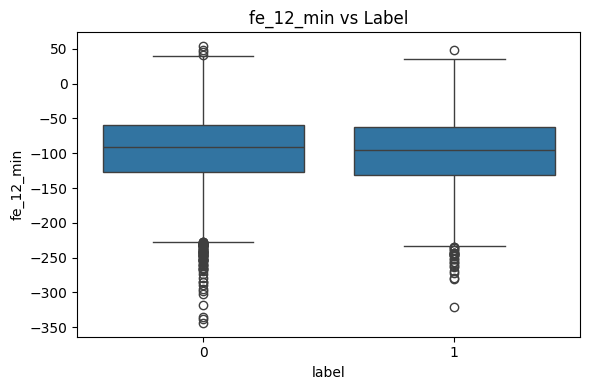

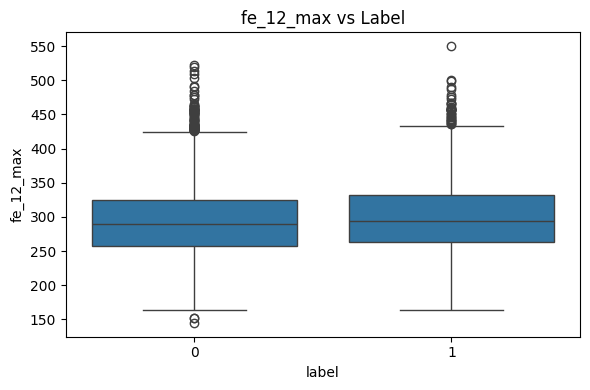

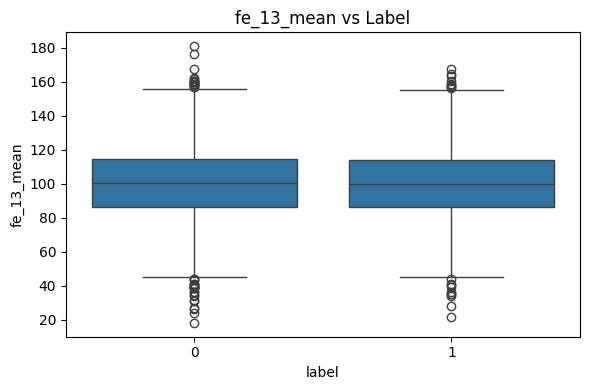

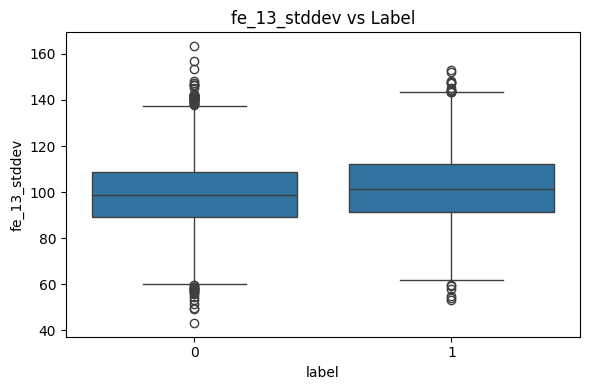

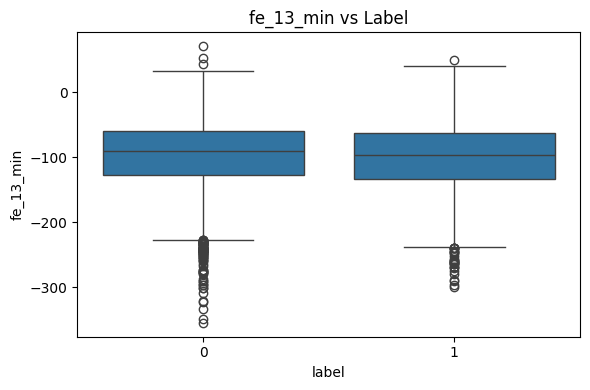

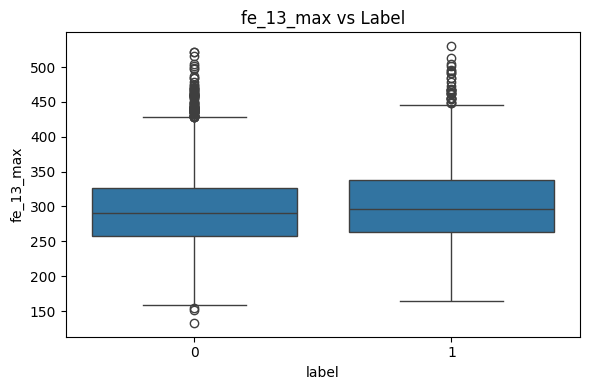

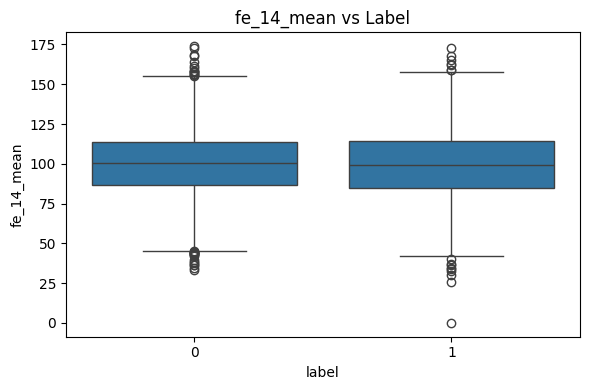

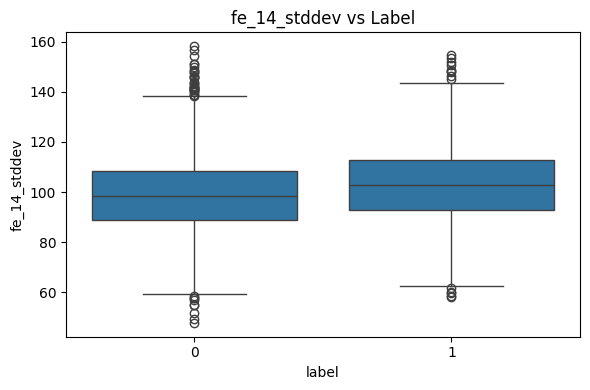

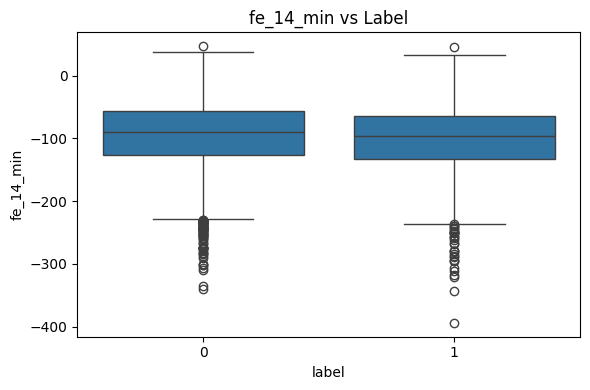

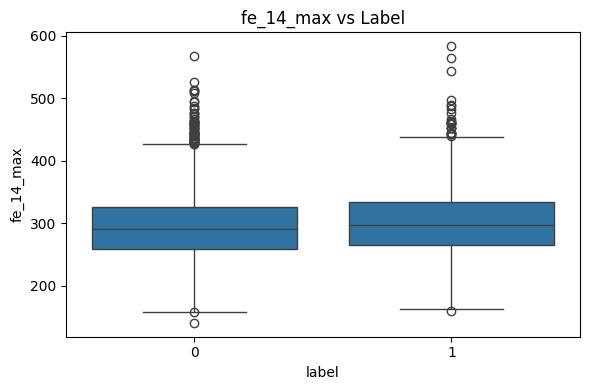

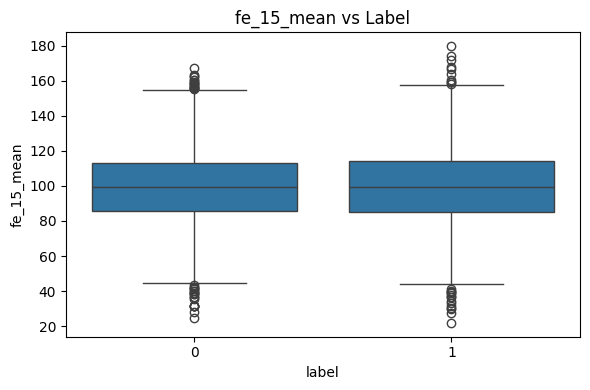

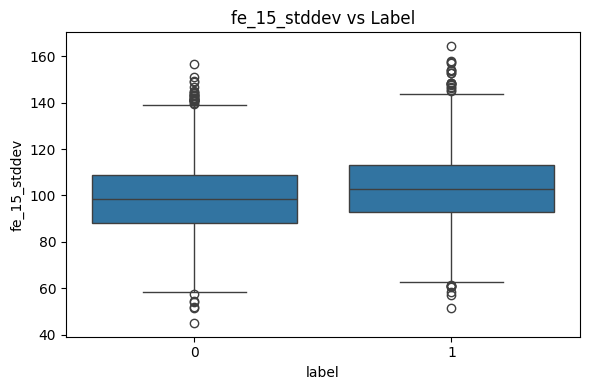

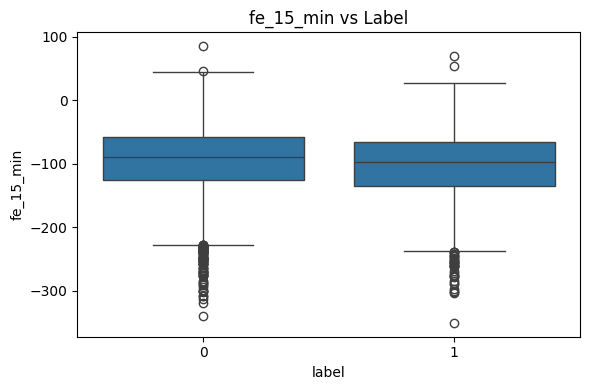

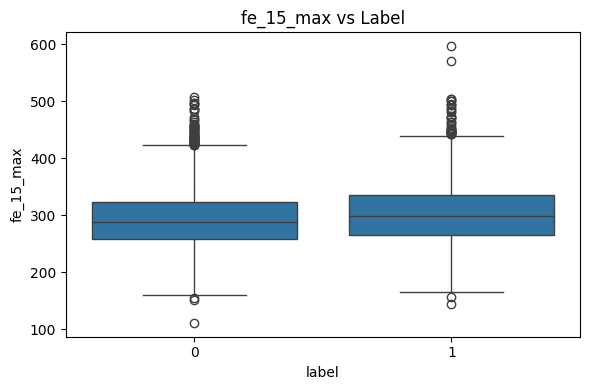

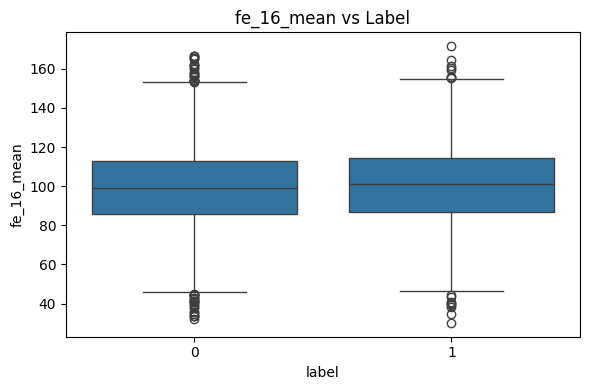

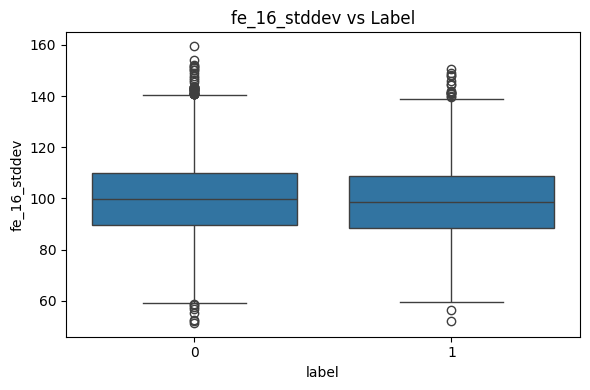

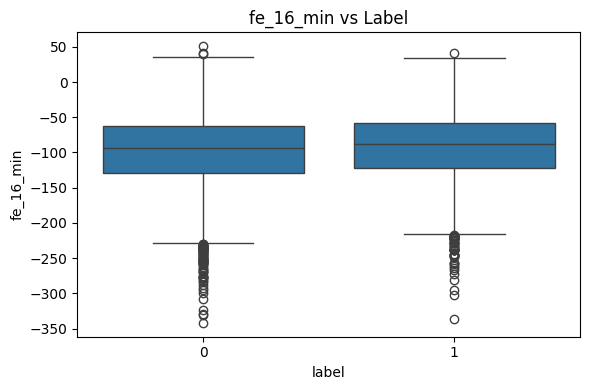

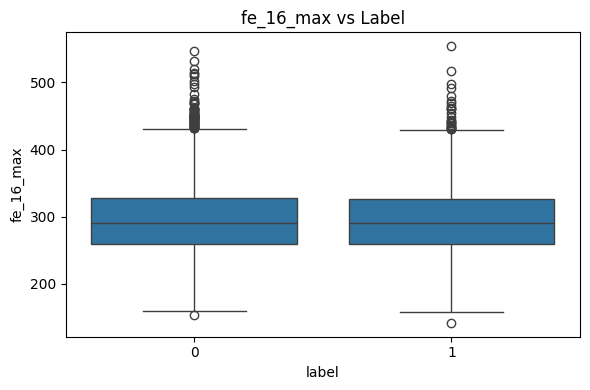

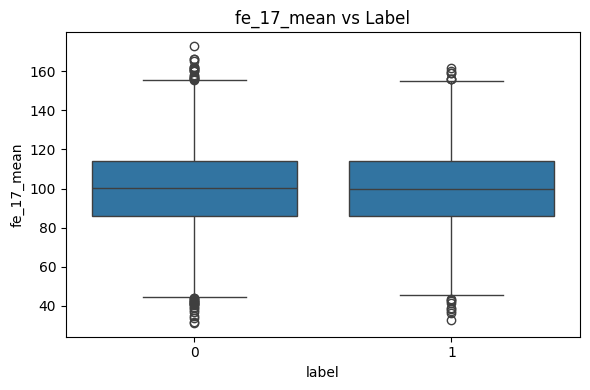

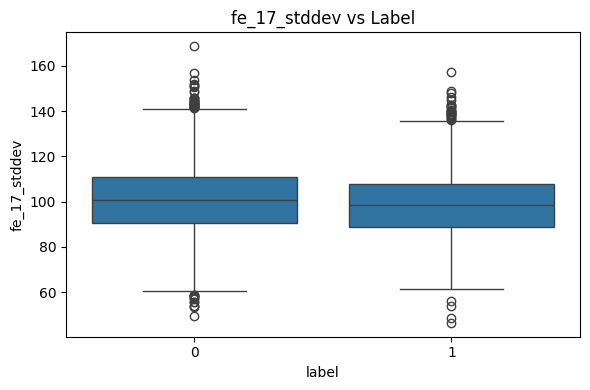

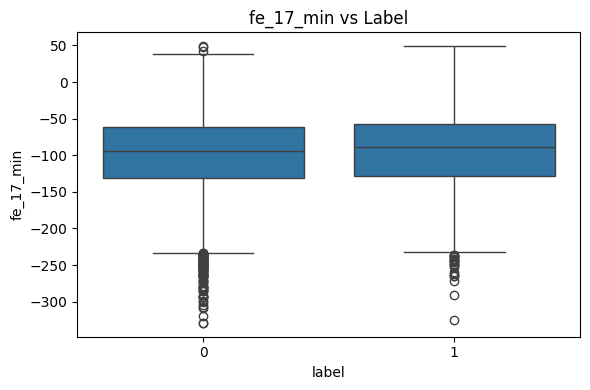

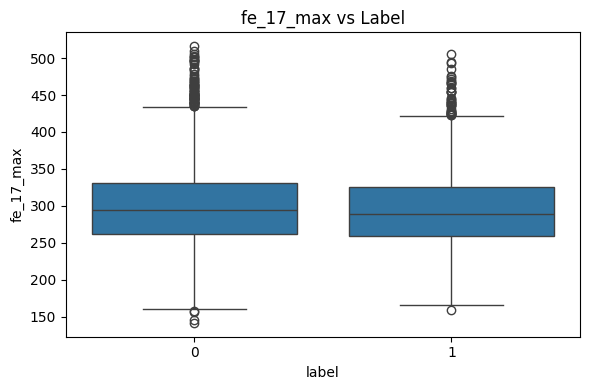

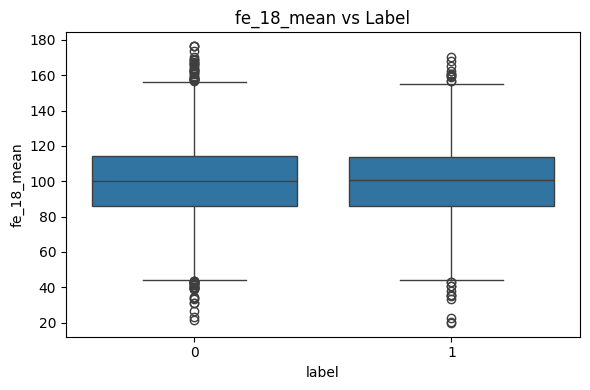

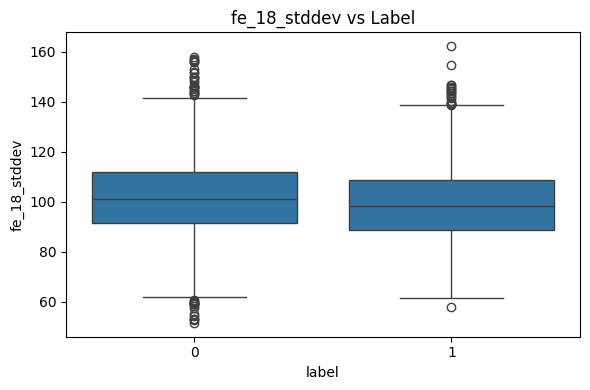

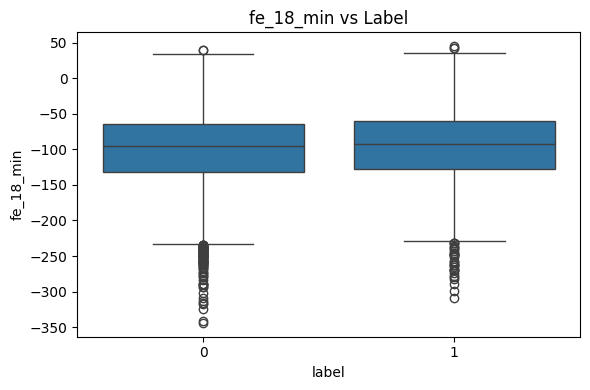

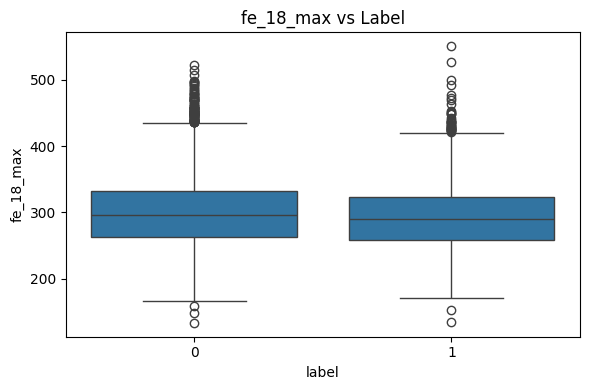

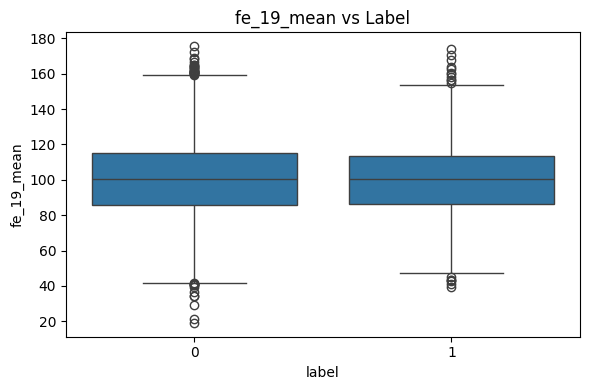

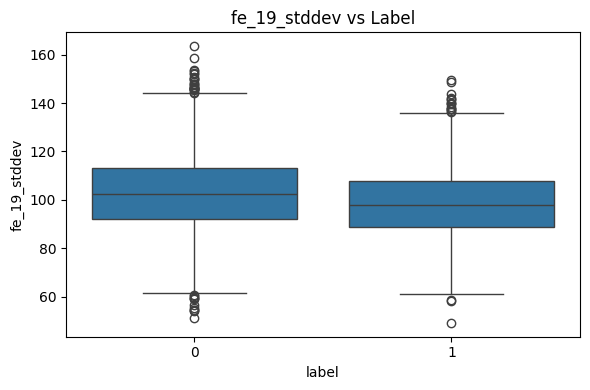

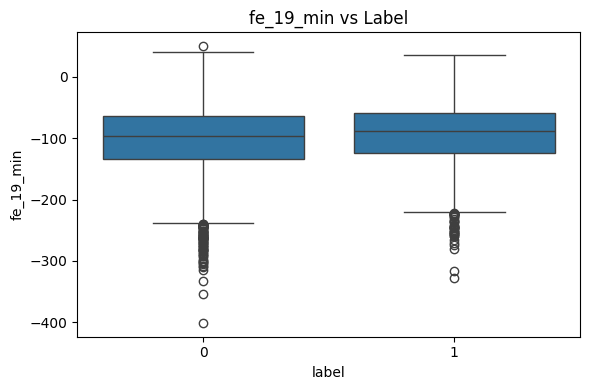

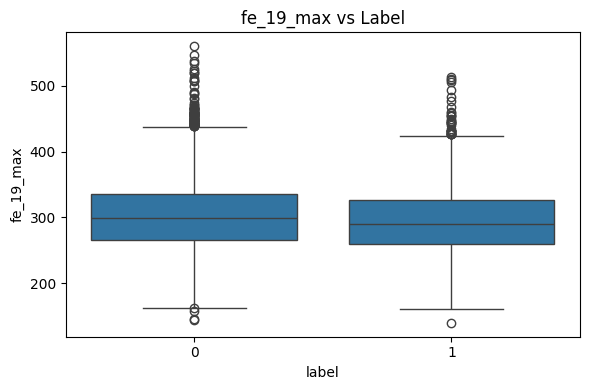

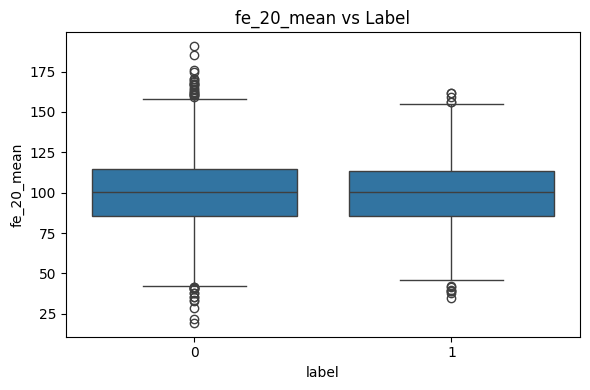

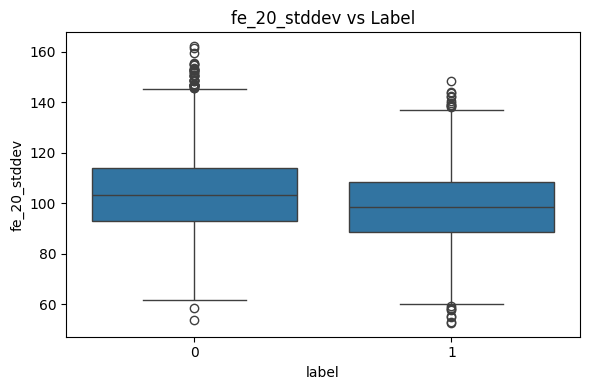

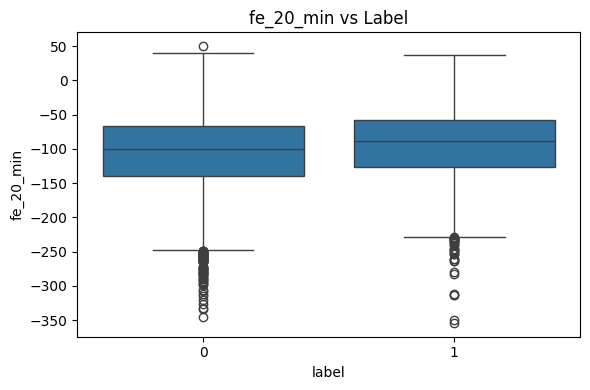

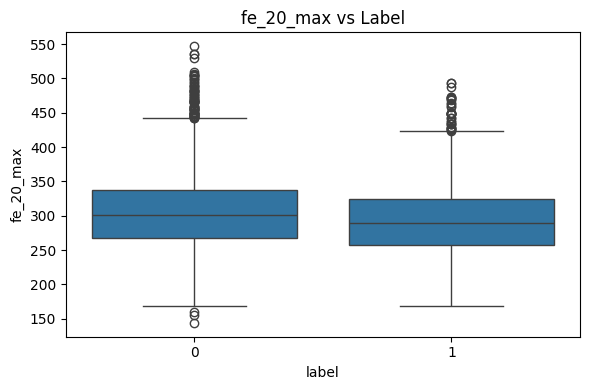

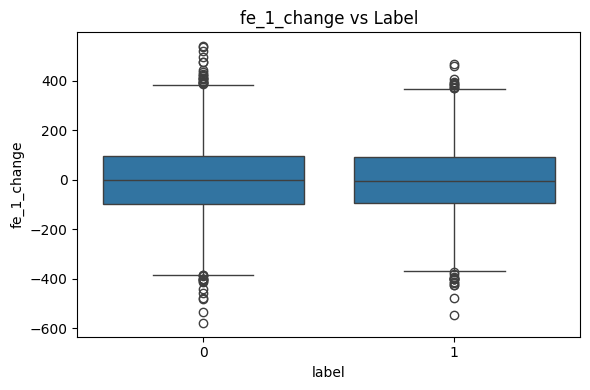

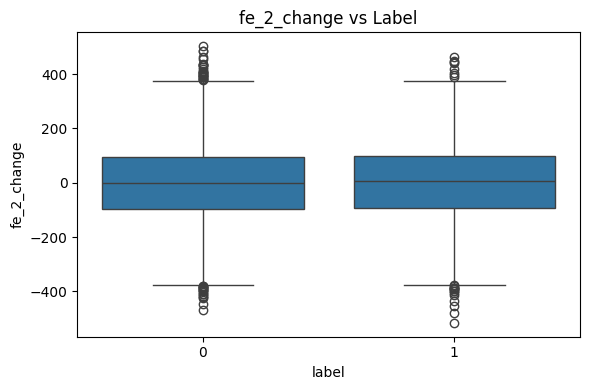

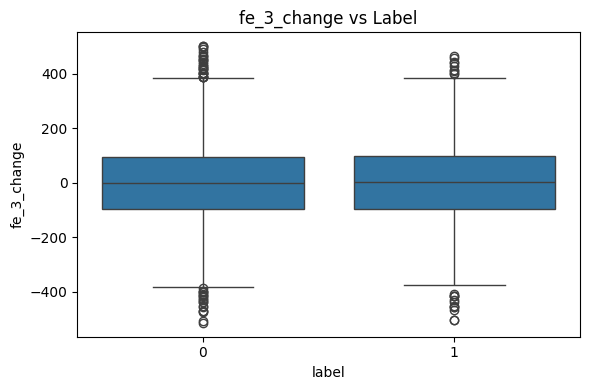

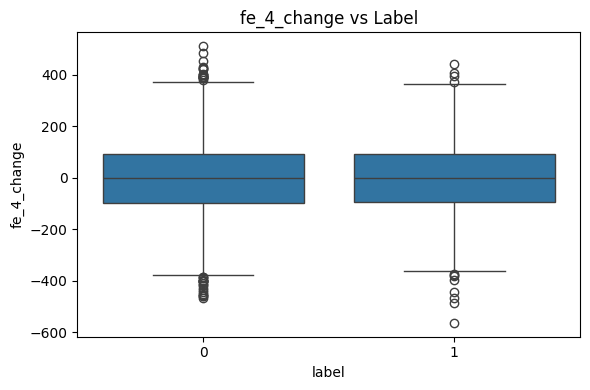

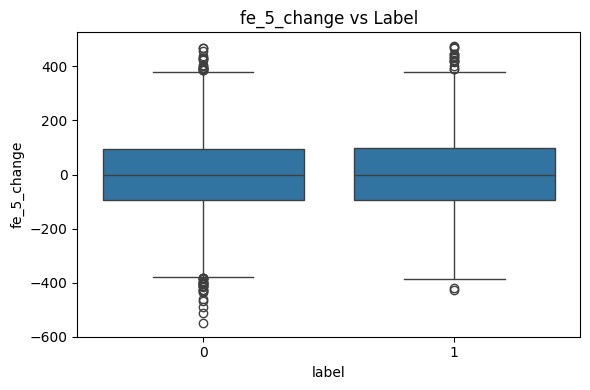

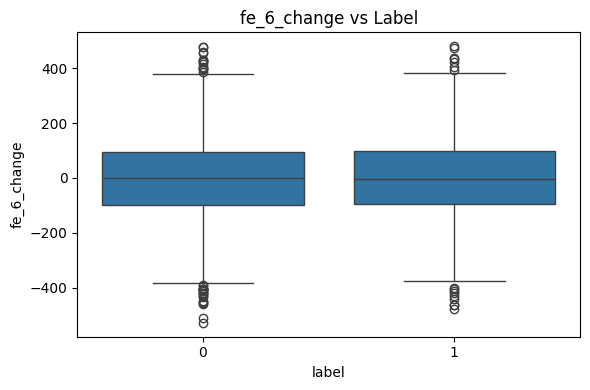

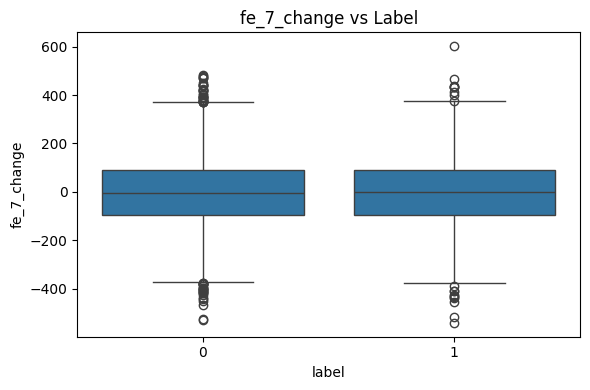

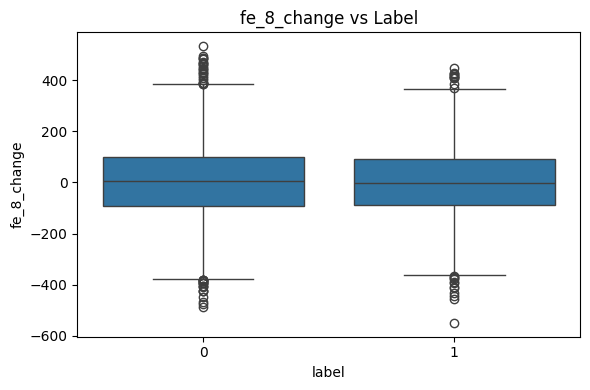

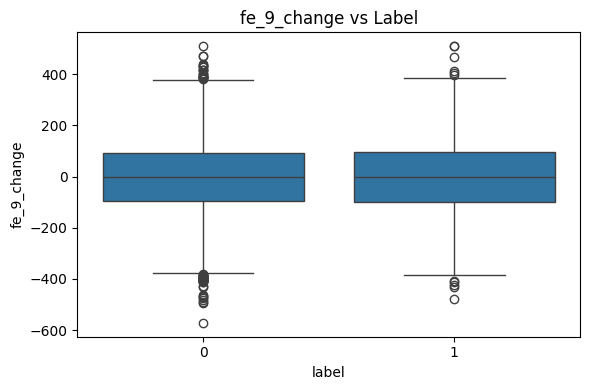

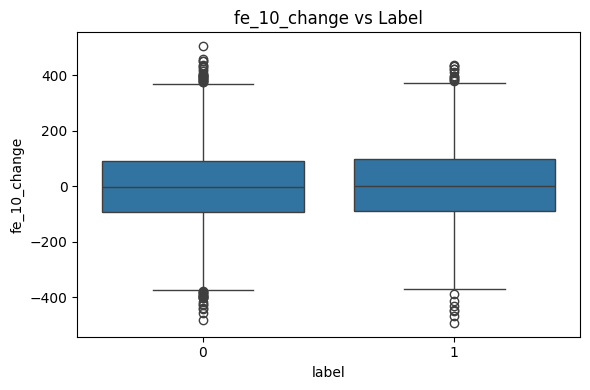

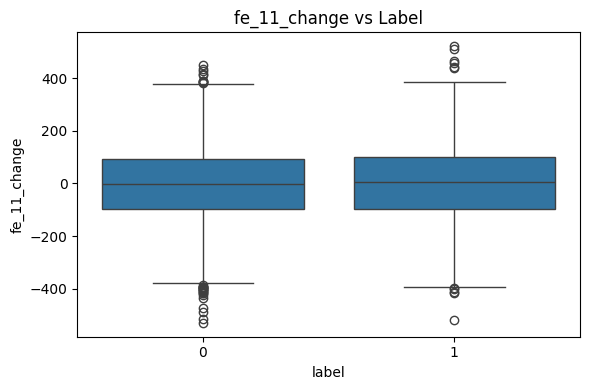

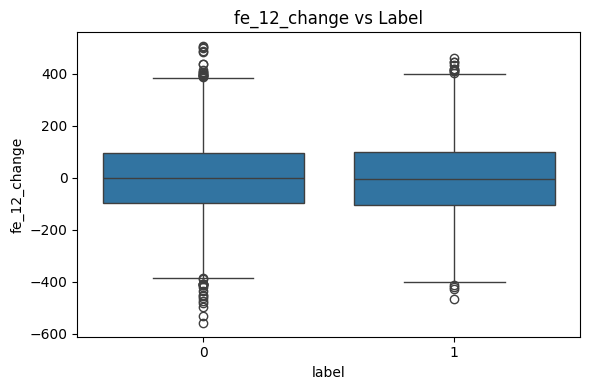

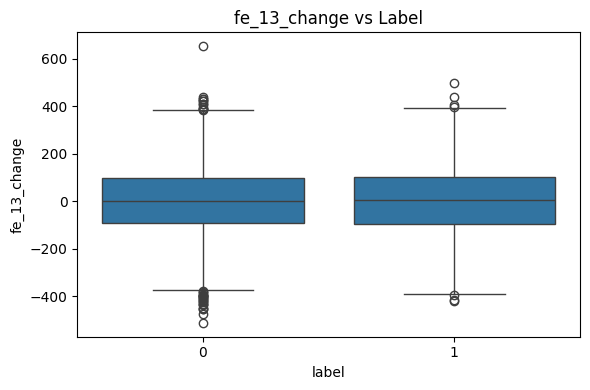

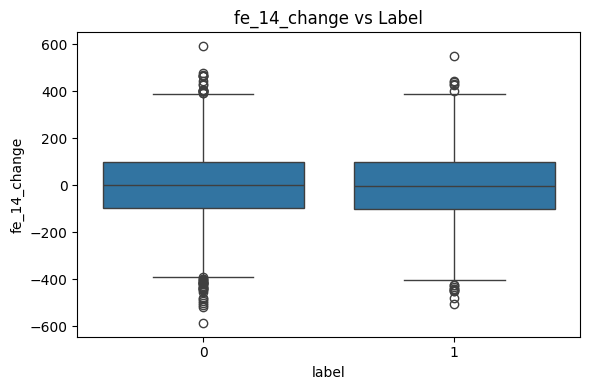

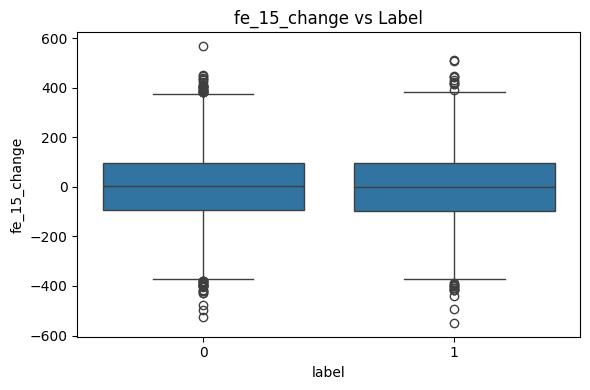

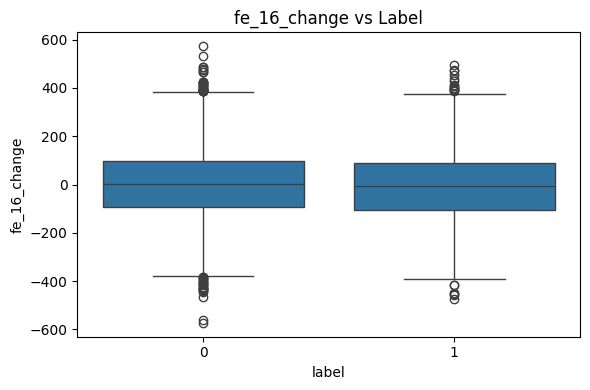

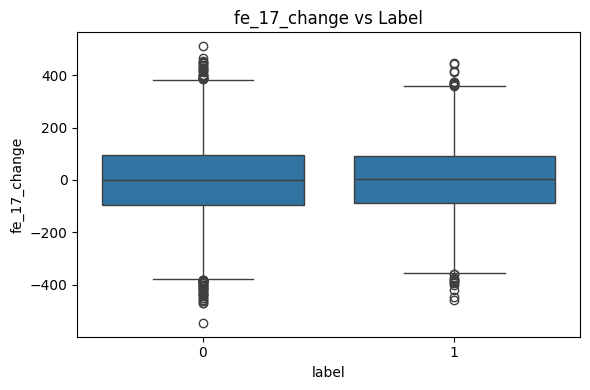

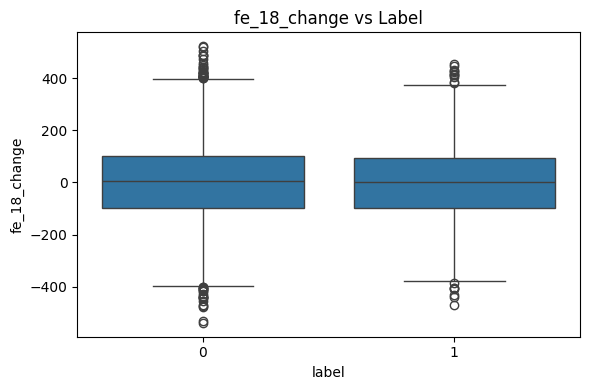

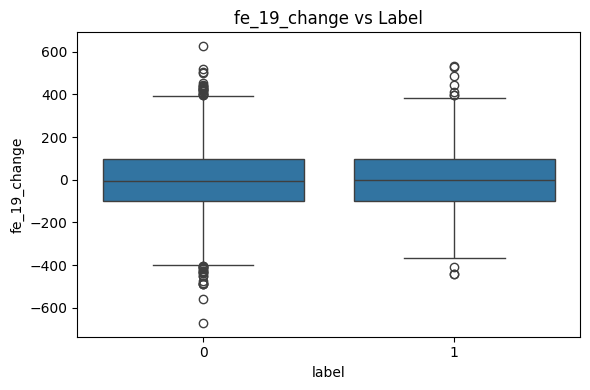

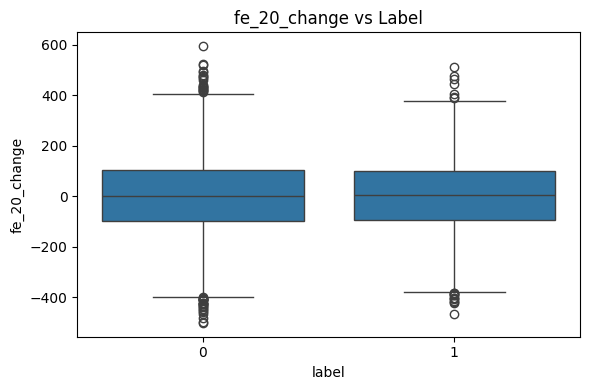

In [20]:
for f_col in features_df_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="label", y=f_col, data=pandas_df)
    plt.title(f"{f_col} vs Label")
    plt.tight_layout()
    plt.show()
    plt.close('all')

Some features such as fe_2_mean, fe_3_min shows some relationship vs the label

### Train a logistic regression model to check if we are on the right track

In [21]:
eda_df.columns

['Customer_ID',
 'loan_id',
 'label',
 'label_def',
 'snapshot_date',
 'fe_1',
 'fe_2',
 'fe_3',
 'fe_4',
 'fe_5',
 'fe_6',
 'fe_7',
 'fe_8',
 'fe_9',
 'fe_10',
 'fe_11',
 'fe_12',
 'fe_13',
 'fe_14',
 'fe_15',
 'fe_16',
 'fe_17',
 'fe_18',
 'fe_19',
 'fe_20',
 'fe_1_mean',
 'fe_1_stddev',
 'fe_1_min',
 'fe_1_max',
 'fe_2_mean',
 'fe_2_stddev',
 'fe_2_min',
 'fe_2_max',
 'fe_3_mean',
 'fe_3_stddev',
 'fe_3_min',
 'fe_3_max',
 'fe_4_mean',
 'fe_4_stddev',
 'fe_4_min',
 'fe_4_max',
 'fe_5_mean',
 'fe_5_stddev',
 'fe_5_min',
 'fe_5_max',
 'fe_6_mean',
 'fe_6_stddev',
 'fe_6_min',
 'fe_6_max',
 'fe_7_mean',
 'fe_7_stddev',
 'fe_7_min',
 'fe_7_max',
 'fe_8_mean',
 'fe_8_stddev',
 'fe_8_min',
 'fe_8_max',
 'fe_9_mean',
 'fe_9_stddev',
 'fe_9_min',
 'fe_9_max',
 'fe_10_mean',
 'fe_10_stddev',
 'fe_10_min',
 'fe_10_max',
 'fe_11_mean',
 'fe_11_stddev',
 'fe_11_min',
 'fe_11_max',
 'fe_12_mean',
 'fe_12_stddev',
 'fe_12_min',
 'fe_12_max',
 'fe_13_mean',
 'fe_13_stddev',
 'fe_13_min',
 'fe_13_m

In [22]:
x_cols = eda_df.columns[5:]
x_cols.append('label')

In [23]:
# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=x_cols, outputCol="features")
assembled_df = assembler.transform(eda_df)

In [24]:
train_df, test_df = assembled_df.randomSplit([0.8, 0.2], seed=42)

In [25]:
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_df)

[Stage 243:>                (0 + 5) / 5][Stage 244:==========>      (3 + 2) / 5]

In [26]:
predictions = lr_model.transform(test_df)

evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f"Test ROC AUC: {roc_auc:.4f}")

Test ROC AUC: 1.0000


### Construct pipeline to build bronze, silver and gold tables

Now that we have a better understanding of the data, lets build our data mart for feature_clickstream data

### Bronze

In [46]:
# def feature_clickstream_bronze_table(snapshot_date_str, bronze_clickstream_directory, spark):
#     # prepare arguments
#     snapshot_date = datetime.strptime(snapshot_date_str, "%Y-%m-%d")
    
#     # connect to source back end - IRL connect to back end source system
#     csv_file_path = "data/feature_clickstream.csv"

#     # load data - IRL ingest from back end source system
#     df = spark.read.csv(csv_file_path, header=True, inferSchema=True).filter(col('snapshot_date') == snapshot_date)
#     print(snapshot_date_str + 'row count:', df.count())

#     # save bronze table to datamart - IRL connect to database to write
#     partition_name = "bronze_clickstream_daily_" + snapshot_date_str.replace('-','_') + '.csv'
#     filepath = bronze_clickstream_directory + partition_name
#     df.toPandas().to_csv(filepath, index=False)
#     print('saved to:', filepath)

#     return df


In [7]:
# create bronze datalake
bronze_clickstream_directory = "datamart/bronze/clickstream/"

if not os.path.exists(bronze_clickstream_directory):
    os.makedirs(bronze_clickstream_directory)

In [49]:
# run bronze backfill
for date_str in dates_str_lst:
    utils.clickstream_bronze_table.feature_clickstream_bronze_table(date_str, bronze_clickstream_directory, spark)


2023-01-01row count: 8974
saved to: datamart/bronze/clickstream/bronze_clickstream_daily_2023_01_01.csv
2023-02-01row count: 8974
saved to: datamart/bronze/clickstream/bronze_clickstream_daily_2023_02_01.csv
2023-03-01row count: 8974
saved to: datamart/bronze/clickstream/bronze_clickstream_daily_2023_03_01.csv
2023-04-01row count: 8974
saved to: datamart/bronze/clickstream/bronze_clickstream_daily_2023_04_01.csv
2023-05-01row count: 8974
saved to: datamart/bronze/clickstream/bronze_clickstream_daily_2023_05_01.csv
2023-06-01row count: 8974
saved to: datamart/bronze/clickstream/bronze_clickstream_daily_2023_06_01.csv
2023-07-01row count: 8974
saved to: datamart/bronze/clickstream/bronze_clickstream_daily_2023_07_01.csv
2023-08-01row count: 8974
saved to: datamart/bronze/clickstream/bronze_clickstream_daily_2023_08_01.csv
2023-09-01row count: 8974
saved to: datamart/bronze/clickstream/bronze_clickstream_daily_2023_09_01.csv
2023-10-01row count: 8974
saved to: datamart/bronze/clickstream/

In [30]:
feature_clickstream_bronze_table(date_str, bronze_clickstream_directory, spark).toPandas()

2024-12-01row count: 8974
saved to: datamart/bronze/clickstream/bronze_clickstream_daily_2024_12_01.csv


,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date
0,145,189,109,134,196,-37,101,82,111,24,...,65,249,200,185,-83,-18,-76,30,CUS_0x1037,2024-12-01
1,40,184,187,75,192,146,38,109,353,141,...,-14,193,125,117,215,91,33,255,CUS_0x1069,2024-12-01
2,98,121,180,200,95,48,59,194,76,84,...,167,101,92,185,98,68,-60,116,CUS_0x114a,2024-12-01
3,85,96,19,47,30,39,-32,210,-81,206,...,143,94,139,237,78,187,77,33,CUS_0x1184,2024-12-01
4,98,45,155,56,112,47,52,138,153,225,...,-43,142,121,10,189,110,264,241,CUS_0x1297,2024-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,414,22,72,57,142,192,11,139,24,63,...,179,91,20,189,-35,-19,15,66,CUS_0xdf6,2024-12-01
8970,116,-124,-108,212,-21,227,146,112,186,-65,...,38,226,319,98,9,152,17,14,CUS_0xe23,2024-12-01
8971,237,-3,-49,375,144,41,-170,324,19,266,...,7,102,64,191,124,220,231,75,CUS_0xe4e,2024-12-01
8972,5,67,211,83,207,-41,325,14,-18,41,...,109,266,28,157,131,116,101,131,CUS_0xedd,2024-12-01


### Silver

In [59]:
# def feature_clickstream_silver_table(snapshot_date_str, bronze_clickstream_directory, silver_clickstream_directory, spark):
#     # prepare arguments
#     snapshot_date = datetime.strptime(snapshot_date_str, "%Y-%m-%d")
    
#     # connect to bronze table
#     partition_name = "bronze_clickstream_daily_" + snapshot_date_str.replace('-','_') + '.csv'
#     filepath = bronze_clickstream_directory + partition_name
#     df = spark.read.csv(filepath, header=True, inferSchema=True)
#     print('loaded from:', filepath, 'row count:', df.count())

#     # clean data: enforce schema / data type
#     # Dictionary specifying columns and their desired datatypes
#     column_type_map = {
#         "fe_1": IntegerType(),
#         "fe_2": IntegerType(),
#         "fe_3": IntegerType(),
#         "fe_4": IntegerType(),
#         "fe_5": IntegerType(),
#         "fe_6": IntegerType(),
#         "fe_7": IntegerType(),
#         "fe_8": IntegerType(),
#         "fe_9": IntegerType(),
#         "fe_10": IntegerType(),
#         "fe_11": IntegerType(),
#         "fe_12": IntegerType(),
#         "fe_13": IntegerType(),
#         "fe_14": IntegerType(),
#         "fe_15": IntegerType(),
#         "fe_16": IntegerType(),
#         "fe_17": IntegerType(),
#         "fe_18": IntegerType(),
#         "fe_19": IntegerType(),
#         "fe_20": IntegerType(),
#         "Customer_ID": StringType(),
#         "snapshot_date": DateType(),
#     }

#     #change to new dtype
#     for column, new_type in column_type_map.items():
#         df = df.withColumn(column, col(column).cast(new_type))

#     # save silver table - IRL connect to database to write
#     partition_name = "silver_clickstream_daily_" + snapshot_date_str.replace('-','_') + '.parquet'
#     filepath = silver_clickstream_directory + partition_name
#     df.write.mode("overwrite").parquet(filepath)
#     # df.toPandas().to_parquet(filepath,
#     #           compression='gzip')
#     print('saved to:', filepath)
    
#     return df

In [8]:
# create silver datalake
silver_clickstream_directory = "datamart/silver/clickstream/"

if not os.path.exists(silver_clickstream_directory):
    os.makedirs(silver_clickstream_directory)

In [9]:
# run silver backfill
for date_str in dates_str_lst:
    utils.clickstream_silver_table.feature_clickstream_silver_table(date_str, bronze_clickstream_directory, silver_clickstream_directory, spark)

loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2023_01_01.csv row count: 8974


saved to: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2023_02_01.csv row count: 8974
saved to: datamart/silver/clickstream/silver_clickstream_daily_2023_02_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2023_03_01.csv row count: 8974


saved to: datamart/silver/clickstream/silver_clickstream_daily_2023_03_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2023_04_01.csv row count: 8974
saved to: datamart/silver/clickstream/silver_clickstream_daily_2023_04_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2023_05_01.csv row count: 8974
saved to: datamart/silver/clickstream/silver_clickstream_daily_2023_05_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2023_06_01.csv row count: 8974


saved to: datamart/silver/clickstream/silver_clickstream_daily_2023_06_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2023_07_01.csv row count: 8974


saved to: datamart/silver/clickstream/silver_clickstream_daily_2023_07_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2023_08_01.csv row count: 8974


saved to: datamart/silver/clickstream/silver_clickstream_daily_2023_08_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2023_09_01.csv row count: 8974


saved to: datamart/silver/clickstream/silver_clickstream_daily_2023_09_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2023_10_01.csv row count: 8974


saved to: datamart/silver/clickstream/silver_clickstream_daily_2023_10_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2023_11_01.csv row count: 8974


saved to: datamart/silver/clickstream/silver_clickstream_daily_2023_11_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2023_12_01.csv row count: 8974


saved to: datamart/silver/clickstream/silver_clickstream_daily_2023_12_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2024_01_01.csv row count: 8974


saved to: datamart/silver/clickstream/silver_clickstream_daily_2024_01_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2024_02_01.csv row count: 8974


saved to: datamart/silver/clickstream/silver_clickstream_daily_2024_02_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2024_03_01.csv row count: 8974


saved to: datamart/silver/clickstream/silver_clickstream_daily_2024_03_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2024_04_01.csv row count: 8974


saved to: datamart/silver/clickstream/silver_clickstream_daily_2024_04_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2024_05_01.csv row count: 8974
saved to: datamart/silver/clickstream/silver_clickstream_daily_2024_05_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2024_06_01.csv row count: 8974


saved to: datamart/silver/clickstream/silver_clickstream_daily_2024_06_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2024_07_01.csv row count: 8974


saved to: datamart/silver/clickstream/silver_clickstream_daily_2024_07_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2024_08_01.csv row count: 8974


saved to: datamart/silver/clickstream/silver_clickstream_daily_2024_08_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2024_09_01.csv row count: 8974
saved to: datamart/silver/clickstream/silver_clickstream_daily_2024_09_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2024_10_01.csv row count: 8974


saved to: datamart/silver/clickstream/silver_clickstream_daily_2024_10_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2024_11_01.csv row count: 8974


saved to: datamart/silver/clickstream/silver_clickstream_daily_2024_11_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2024_12_01.csv row count: 8974
saved to: datamart/silver/clickstream/silver_clickstream_daily_2024_12_01.parquet


In [37]:
feature_clickstream_silver_table(date_str, bronze_clickstream_directory, silver_clickstream_directory, spark).toPandas()

loaded from: datamart/bronze/clickstream/bronze_clickstream_daily_2024_12_01.csv row count: 8974
saved to: datamart/silver/clickstream/silver_clickstream_daily_2024_12_01.parquet


,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date
0,145,189,109,134,196,-37,101,82,111,24,...,65,249,200,185,-83,-18,-76,30,CUS_0x1037,2024-12-01
1,40,184,187,75,192,146,38,109,353,141,...,-14,193,125,117,215,91,33,255,CUS_0x1069,2024-12-01
2,98,121,180,200,95,48,59,194,76,84,...,167,101,92,185,98,68,-60,116,CUS_0x114a,2024-12-01
3,85,96,19,47,30,39,-32,210,-81,206,...,143,94,139,237,78,187,77,33,CUS_0x1184,2024-12-01
4,98,45,155,56,112,47,52,138,153,225,...,-43,142,121,10,189,110,264,241,CUS_0x1297,2024-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,414,22,72,57,142,192,11,139,24,63,...,179,91,20,189,-35,-19,15,66,CUS_0xdf6,2024-12-01
8970,116,-124,-108,212,-21,227,146,112,186,-65,...,38,226,319,98,9,152,17,14,CUS_0xe23,2024-12-01
8971,237,-3,-49,375,144,41,-170,324,19,266,...,7,102,64,191,124,220,231,75,CUS_0xe4e,2024-12-01
8972,5,67,211,83,207,-41,325,14,-18,41,...,109,266,28,157,131,116,101,131,CUS_0xedd,2024-12-01


### Gold

In [10]:
# def feature_clickstream_gold_table(snapshot_date_str, silver_clickstream_directory, gold_clickstream_directory, spark):
    
#     # prepare arguments
#     snapshot_date = datetime.strptime(snapshot_date_str, "%Y-%m-%d")
    
#     # connect to bronze table
#     partition_name = "silver_clickstream_daily_" + snapshot_date_str.replace('-','_') + '.parquet'
#     filepath = silver_clickstream_directory + partition_name
#     df = spark.read.parquet(filepath)
#     print('loaded from:', filepath, 'row count:', df.count())

#     # Feature engineering
#     # List of feature columns
#     feature_cols = [f"fe_{i}" for i in range(1, 21)]

#     # Keep only latest record for each customer
#     # Latest Snapshot Features (per customer)
#     latest_window = Window.partitionBy("Customer_ID").orderBy(F.col("snapshot_date").desc())
    
#     latest_df = df.withColumn("row_num", F.row_number().over(latest_window)) \
#                   .filter(F.col("row_num") == 1) \
#                   .drop("row_num")

#     # Aggregated Features (per customer across all time)
#     agg_exprs = []
#     for f_col in feature_cols:
#         agg_exprs.extend([
#             F.mean(f_col).alias(f"{f_col}_mean"),
#             F.stddev(f_col).alias(f"{f_col}_stddev"),
#             F.min(f_col).alias(f"{f_col}_min"),
#             F.max(f_col).alias(f"{f_col}_max"),
#         ])
    
#     agg_df = df.groupBy("Customer_ID").agg(*agg_exprs)

#     #Lag/Change Features (difference from previous snapshot)
#     lag_window = Window.partitionBy("Customer_ID").orderBy("snapshot_date")
    
#     df_with_lags = df
#     for f_col in feature_cols:
#         df_with_lags = df_with_lags.withColumn(f"{f_col}_lag", F.lag(f_col).over(lag_window))
#         df_with_lags = df_with_lags.withColumn(f"{f_col}_change", F.col(f_col) - F.col(f"{f_col}_lag"))
    
#     # Get the most recent change row per customer
#     latest_changes = df_with_lags.withColumn("row_num", F.row_number().over(latest_window)) \
#                                  .filter("row_num = 1") \
#                                  .select("Customer_ID", *[f"{c}_change" for c in feature_cols])

#     # Combine all features
#     # Start with most recent snapshot (base)
#     features_df = latest_df.select("Customer_ID", *feature_cols)
    
#     # Join all blocks
#     df = features_df \
#         .join(agg_df, on="Customer_ID", how="left") \
#         .join(latest_changes, on="Customer_ID", how="left")


#     # save gold table - IRL connect to database to write
#     partition_name = "gold_clickstream_daily_" + snapshot_date_str.replace('-','_') + '.parquet'
#     filepath = gold_clickstream_directory + partition_name
#     df.write.mode("overwrite").parquet(filepath)
#     # df.toPandas().to_parquet(filepath,
#     #           compression='gzip')
#     print('saved to:', filepath)
    
#     return df

In [11]:
# create silver datalake
gold_clickstream_directory = "datamart/gold/clickstream/"

if not os.path.exists(gold_clickstream_directory):
    os.makedirs(gold_clickstream_directory)

In [12]:
# run gold backfill
for date_str in dates_str_lst:
    utils.clickstream_gold_table.feature_clickstream_gold_table(snapshot_date_str, silver_clickstream_directory, gold_clickstream_directory, spark)

loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974


saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974


saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974


saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974


saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974


saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974
saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974
saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974


saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974
saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974


saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974
saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974


saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974


saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974


saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974


saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974


saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974


saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974


saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974


saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974
saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974


saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974
saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974


saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet
loaded from: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet row count: 8974


saved to: datamart/gold/clickstream/gold_clickstream_daily_2023_01_01.parquet


In [43]:
folder_path = gold_clickstream_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

df.show()

row_count: 8974
+-----------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---------+-----------+--------+--------+---------+-----------+--------+--------+---------+-----------+--------+--------+---------+-----------+--------+--------+---------+-----------+--------+--------+---------+-----------+--------+--------+---------+-----------+--------+--------+---------+-----------+--------+--------+---------+-----------+--------+--------+----------+------------+---------+---------+----------+------------+---------+---------+----------+------------+---------+---------+----------+------------+---------+---------+----------+------------+---------+---------+----------+------------+---------+---------+----------+------------+---------+---------+----------+------------+---------+---------+----------+------------+---------+---------+----------+------------+---------+---------+----------+------------+---------+---------+-----------+----

In [44]:
df.printSchema()

root
 |-- Customer_ID: string (nullable = true)
 |-- fe_1: integer (nullable = true)
 |-- fe_2: integer (nullable = true)
 |-- fe_3: integer (nullable = true)
 |-- fe_4: integer (nullable = true)
 |-- fe_5: integer (nullable = true)
 |-- fe_6: integer (nullable = true)
 |-- fe_7: integer (nullable = true)
 |-- fe_8: integer (nullable = true)
 |-- fe_9: integer (nullable = true)
 |-- fe_10: integer (nullable = true)
 |-- fe_11: integer (nullable = true)
 |-- fe_12: integer (nullable = true)
 |-- fe_13: integer (nullable = true)
 |-- fe_14: integer (nullable = true)
 |-- fe_15: integer (nullable = true)
 |-- fe_16: integer (nullable = true)
 |-- fe_17: integer (nullable = true)
 |-- fe_18: integer (nullable = true)
 |-- fe_19: integer (nullable = true)
 |-- fe_20: integer (nullable = true)
 |-- fe_1_mean: double (nullable = true)
 |-- fe_1_stddev: double (nullable = true)
 |-- fe_1_min: integer (nullable = true)
 |-- fe_1_max: integer (nullable = true)
 |-- fe_2_mean: double (nullable = 